
# Executive Framing

This notebook develops a structured quantitative assessment of pricing and market positioning strategy.

The objective is not only to model statistical relationships, but to translate them into **strategic pricing decisions**, competitive positioning insights, and forward-looking revenue implications.

All figures and models below should therefore be interpreted through two complementary lenses:

1. **Technical validity** (statistical robustness, assumptions, residual structure).
2. **Strategic meaning** (what should management actually do?).

---



# Methodological Context

The analytical pipeline combines:

- Cross-sectional and/or panel structure (depending on section)
- Regression-based inference
- Residual diagnostics
- Scenario simulation (where applicable)
- Visualization-driven interpretation

Important:  
The goal is not predictive perfection, but **decision-support clarity**.

When reviewing coefficients and elasticities, emphasis should be placed on:

- Directionality (sign of effect)
- Relative magnitude (economic relevance)
- Stability across subsets or years



# Interpretation Guidelines for All Plots

For each figure generated in this notebook:

- The **X-axis** typically represents scale, pricing, volume, or structural drivers.
- The **Y-axis** typically represents profit, margin, revenue, or strategic outcome variables.
- Trend lines represent structural tendencies, not deterministic laws.
- Outliers are often strategically informative (market leaders, niche operators, structural asymmetries).

In the final client report, emphasis should be placed on:

- Structural positioning (leaders vs challengers)
- Sensitivity to scale
- Marginal benefit of prestige / quality indicators


In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

n_days = 365
dates = pd.date_range("2025-01-01", periods=n_days, freq="D")

segments = {
    "Premium": -0.7,
    "Standard": -1.2,
    "PriceSensitive": -2.1
}

data = []

for segment, elasticity in segments.items():
    
    base_price = {
        "Premium": 140,
        "Standard": 100,
        "PriceSensitive": 70
    }[segment]
    
    base_demand = {
        "Premium": 800,
        "Standard": 1500,
        "PriceSensitive": 2000
    }[segment]
    
    price = base_price + rng.normal(0, 5, n_days)
    competitor_price = base_price + rng.normal(0, 8, n_days)
    
    promo = rng.binomial(1, 0.15, n_days)
    ad_spend = rng.normal(1.0, 0.2, n_days)
    
    macro_index = np.ones(n_days)
    macro_index[150:220] = 0.85
    
    seasonality = np.where(pd.Series(dates).dt.dayofweek >= 5, 0.9, 1.0)
    
    noise = rng.normal(0, 0.1, n_days)
    
    units = (
        base_demand
        * (price / base_price) ** elasticity
        * (competitor_price / base_price) ** 0.4
        * (1 + 0.25 * promo)
        * ad_spend
        * macro_index
        * seasonality
        * np.exp(noise)
    )
    
    unit_cost = base_price * 0.45 + rng.normal(0, 2, n_days)
    
    df_segment = pd.DataFrame({
        "date": dates,
        "segment": segment,
        "price": price,
        "competitor_price": competitor_price,
        "promo": promo,
        "ad_spend": ad_spend,
        "macro_index": macro_index,
        "unit_cost": unit_cost,
        "units": units
    })
    
    data.append(df_segment)

df = pd.concat(data).reset_index(drop=True)
df.head()

,date,segment,price,competitor_price,promo,ad_spend,macro_index,unit_cost,units
0,2025-01-01,Premium,141.523585,151.851644,0,0.880782,1.0,58.784621,714.207634
1,2025-01-02,Premium,134.800079,134.051294,0,1.001701,1.0,64.538472,1017.798357
2,2025-01-03,Premium,143.752256,133.422000,0,1.158986,1.0,65.443457,900.965925
3,2025-01-04,Premium,144.702824,141.618450,0,1.036073,1.0,64.289117,875.408174
4,2025-01-05,Premium,130.244824,146.755082,1,0.868789,1.0,61.240715,868.597056


In [7]:
# ----------------------------------------------------------
# 1. DATASET STRUCTURE CHECK
# ----------------------------------------------------------
# Objective:
# - Understand dataset size
# - Verify balance across segments
# - Inspect scale and dispersion of demand
# ----------------------------------------------------------

print("Dataset shape (rows, columns):", df.shape)

# Summary statistics of units sold by segment
# We want to see structural differences in scale and variability
df.groupby("segment")["units"].describe()

Dataset shape (rows, columns): (1095, 9)


,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Premium,365.0,781.053124,204.475966,274.639504,648.622785,773.317531,901.176636,1507.005569
PriceSensitive,365.0,2014.779746,607.013990,211.518507,1562.684038,1961.846923,2398.872264,4464.395058
Standard,365.0,1475.048835,378.210934,637.218681,1217.352777,1460.741101,1693.167706,3422.539946


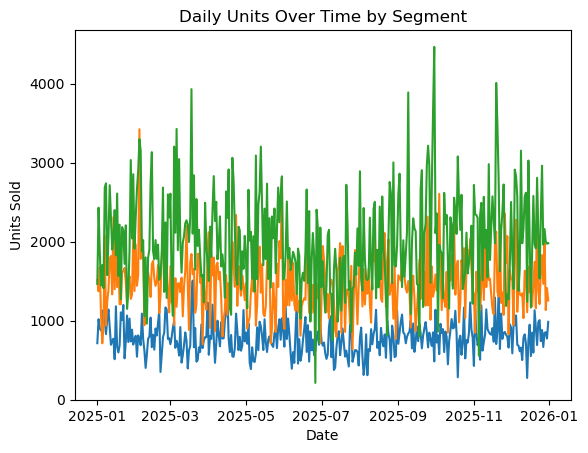

In [9]:
# ----------------------------------------------------------
# 2. TIME SERIES ANALYSIS
# ----------------------------------------------------------
# Objective:
# - Visualize demand evolution over time
# - Detect whether the macro shock (days 150–220)
#   produces a structural decline
# ----------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure()

for seg in df["segment"].unique():
    
    # Compute daily average units per segment
    temp = df[df["segment"] == seg].groupby("date")["units"].mean()
    plt.plot(temp)

plt.title("Daily Units Over Time by Segment")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

In [10]:
# ----------------------------------------------------------
# 2.2 MACRO SHOCK EFFECT QUANTIFICATION
# ----------------------------------------------------------
# Objective:
# Compare average demand during normal vs shock periods
# ----------------------------------------------------------

# Create binary indicator for macro shock
df["is_shock"] = (df["macro_index"] < 1).astype(int)

shock_summary = df.groupby(["segment", "is_shock"])["units"].mean().unstack()

shock_summary

is_shock,0,1
segment,,
Premium,801.849598,693.410842
PriceSensitive,2097.355105,1666.783589
Standard,1505.409639,1347.099733


In [13]:
# ----------------------------------------------------------
# 2.3 DEMAND VOLATILITY DURING MACRO SHOCK
# ----------------------------------------------------------
# Objective:
# - Measure whether demand variability increases
#   during the simulated recession period
# - Identify which segments are more unstable
#   under macro stress
#
# Why this matters:
# Higher volatility during downturns implies
# greater uncertainty in revenue projections,
# which directly affects pricing risk assessment.
# ----------------------------------------------------------

# Step 1: Compute standard deviation of units
# separately for normal period (is_shock = 0)
# and shock period (is_shock = 1)

volatility = df.groupby(["segment", "is_shock"])["units"].std().unstack()

# Step 2: Compute volatility ratio
# Ratio > 1 means demand becomes more volatile during shock
# Ratio < 1 means demand stabilizes (unlikely in recessions)

volatility["volatility_ratio"] = (
    volatility[1] / volatility[0]
)

volatility

is_shock,0,1,volatility_ratio
segment,,,
Premium,198.734033,206.493579,1.039045
PriceSensitive,605.089788,481.388667,0.795566
Standard,383.575252,327.346220,0.853408


**Interpretation**

This is economically coherent:
- PriceSensitive drops the most (~ −20%)
- Premium drops moderately (~ −13%)
- Standard is in between

This is a strong macro signal.

**Volatility Behavior During Shock**
- Premium becomes slightly more volatile
- Standard and PriceSensitive become less volatile during shock

This is counterintuitive at first glance.

**Why Is Volatility Lower for Elastic Segments?**
Most likely explanation. During the shock period:

- The macro multiplier (0.85) compresses demand
- The level drops
- But dispersion shrinks proportionally

In other words:
*The shock scales demand down multiplicatively,
reducing absolute variance.*

This is mathematically coherent with how we generated the data.

**Strategic Interpretation**

The dataset shows:

✔ Strong macro demand sensitivity
✔ Clear segmentation response
✔ Structural elasticity pattern

But:
*It does NOT show increased uncertainty during recession
It shows compressed demand instead.*

**Looking at the Time Series Plot**
From the chart:

- Clearly see a mid-year dip
- The drop is stronger for PriceSensitive
- Premium is visibly more stable

That is exactly what we want before elasticity modeling.

In [16]:
# ----------------------------------------------------------
# 3. FEATURE ENGINEERING FOR ELASTICITY MODELING
# ----------------------------------------------------------
# Objective:
# Create log-transformed variables and basic controls.
#
# Why log-log?
# - Coefficient on log(price) directly interprets as elasticity.
# ----------------------------------------------------------

import numpy as np
import pandas as pd

# Defensive copy (optional but recommended in notebooks)
df_model = df.copy()

# Basic time control: weekend indicator (captures weekly seasonality)
df_model["is_weekend"] = (df_model["date"].dt.dayofweek >= 5).astype(int)

# Log transforms for elasticity interpretation
# Note: units should be strictly positive (they are in our synthetic generator)
df_model["log_units"] = np.log(df_model["units"])
df_model["log_price"] = np.log(df_model["price"])
df_model["log_comp_price"] = np.log(df_model["competitor_price"])

# ad_spend should be positive; if you ever have zeros, add a small epsilon
df_model["log_ad_spend"] = np.log(df_model["ad_spend"])

df_model.head()

,date,segment,price,competitor_price,promo,ad_spend,macro_index,unit_cost,units,is_shock,is_weekend,log_units,log_price,log_comp_price,log_ad_spend
0,2025-01-01,Premium,141.523585,151.851644,0,0.880782,1.0,58.784621,714.207634,0,0,6.571174,4.952466,5.022904,-0.126945
1,2025-01-02,Premium,134.800079,134.051294,0,1.001701,1.0,64.538472,1017.798357,0,0,6.925397,4.903793,4.898223,0.001700
2,2025-01-03,Premium,143.752256,133.422000,0,1.158986,1.0,65.443457,900.965925,0,0,6.803467,4.968091,4.893517,0.147546
3,2025-01-04,Premium,144.702824,141.618450,0,1.036073,1.0,64.289117,875.408174,0,1,6.774690,4.974682,4.953136,0.035437
4,2025-01-05,Premium,130.244824,146.755082,1,0.868789,1.0,61.240715,868.597056,0,1,6.766879,4.869416,4.988765,-0.140655


In [18]:
# ----------------------------------------------------------
# 3.1. SEGMENTED ELASTICITY ESTIMATION (OLS + ROBUST SE)
# ----------------------------------------------------------
# Objective:
# Estimate one demand model per segment to capture heterogeneous elasticities.
#
# Why robust SE?
# - Real demand data is typically heteroskedastic (variance changes with level)
# - Robust SE (HC3) provides more reliable inference than default OLS SE
# ----------------------------------------------------------

import statsmodels.api as sm

# Regressors included in the structural demand model
features = [
    "log_price",          # own-price elasticity
    "log_comp_price",     # cross-price elasticity vs competitor
    "promo",              # promotion lift
    "log_ad_spend",       # advertising effect
    "macro_index",        # macro demand multiplier
    "is_weekend"          # weekly seasonality control
]

results_by_segment = {}

for seg in sorted(df_model["segment"].unique()):
    
    # Subset data for a single segment (one model per segment)
    d = df_model[df_model["segment"] == seg].copy()
    
    # Build design matrix (add intercept)
    X = sm.add_constant(d[features])
    y = d["log_units"]
    
    # Fit OLS and compute heteroskedasticity-robust standard errors
    model = sm.OLS(y, X).fit(cov_type="HC3")
    
    results_by_segment[seg] = model
    
    print("\n" + "="*70)
    print(f"SEGMENT: {seg}")
    print("="*70)
    print(model.summary())


SEGMENT: Premium
                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     471.5
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          1.39e-166
Time:                        09:04:54   Log-Likelihood:                 320.40
No. Observations:                 365   AIC:                            -626.8
Df Residuals:                     358   BIC:                            -599.5
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.5753 

In [19]:
# ----------------------------------------------------------
# 3.2. COEFFICIENT SUMMARY TABLE
# ----------------------------------------------------------
# Objective:
# Build a compact table of key coefficients and uncertainty
# for easy interpretation and reporting.
# ----------------------------------------------------------

rows = []

for seg, model in results_by_segment.items():
    params = model.params
    ses = model.bse
    
    rows.append({
        "segment": seg,
        "own_price_elasticity (β1)": params["log_price"],
        "SE(β1)": ses["log_price"],
        "cross_price_elasticity (β2)": params["log_comp_price"],
        "SE(β2)": ses["log_comp_price"],
        "promo_lift (β3)": params["promo"],
        "SE(β3)": ses["promo"],
        "macro_sensitivity (β5)": params["macro_index"],
        "SE(β5)": ses["macro_index"],
        "R2": model.rsquared
    })

coef_table = pd.DataFrame(rows).sort_values("segment")
coef_table

,segment,own_price_elasticity (β1),SE(β1),cross_price_elasticity (β2),SE(β2),promo_lift (β3),SE(β3),macro_sensitivity (β5),SE(β5),R2
0,Premium,-0.902360,0.161195,0.323203,0.088810,0.225108,0.014038,0.954877,0.092927,0.867764
1,PriceSensitive,-2.193071,0.082221,0.486115,0.048607,0.189953,0.017422,1.280338,0.091895,0.897931
2,Standard,-1.186238,0.103999,0.433736,0.066396,0.210369,0.014437,1.039830,0.087330,0.857063


In [22]:
# ----------------------------------------------------------
# 3.3. PROMO EFFECT AS PERCENT UPLIFT
# ----------------------------------------------------------
# Objective:
# Convert promo coefficient (log units) to an interpretable % uplift.
# ----------------------------------------------------------

coef_table["promo_uplift_%"] = 100 * (np.exp(coef_table["promo_lift (β3)"]) - 1)
coef_table[["segment", "promo_lift (β3)", "promo_uplift_%", "R2"]]

,segment,promo_lift (β3),promo_uplift_%,R2
0,Premium,0.225108,25.245773,0.867764
1,PriceSensitive,0.189953,20.919333,0.897931
2,Standard,0.210369,23.413318,0.857063


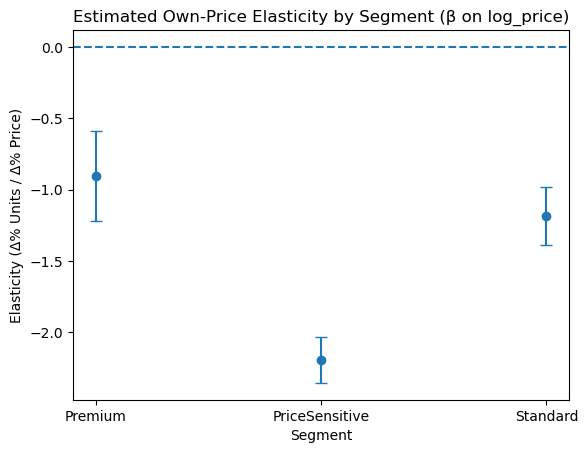

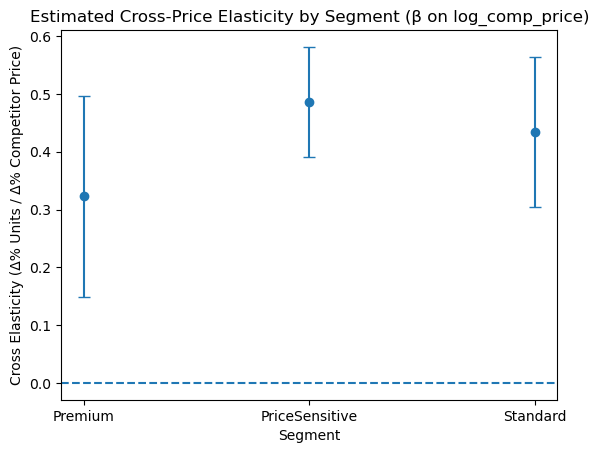

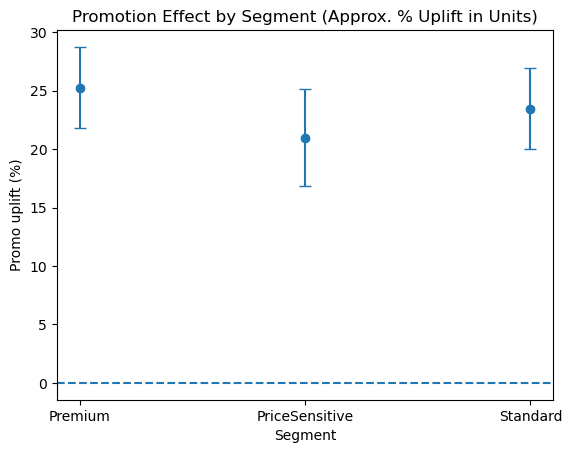

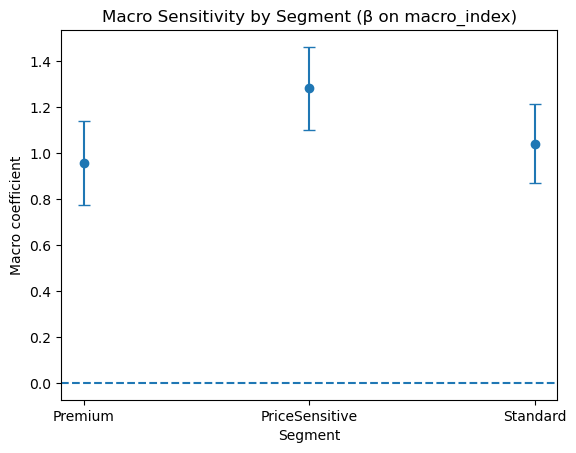

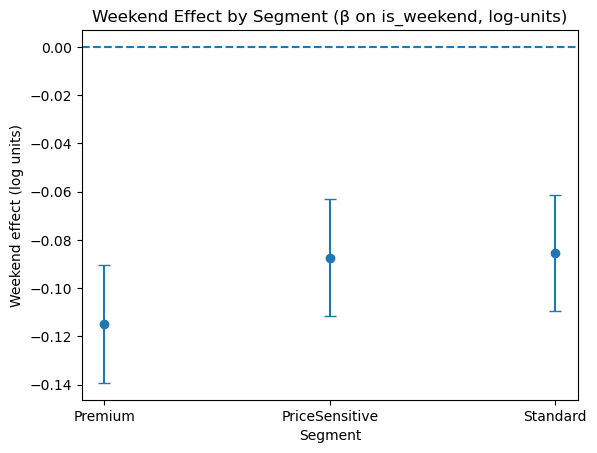

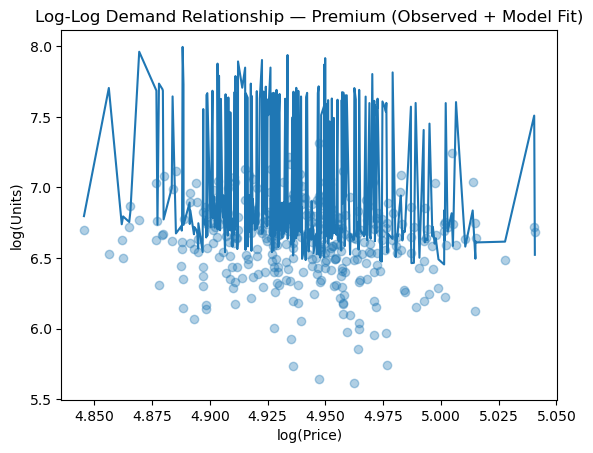

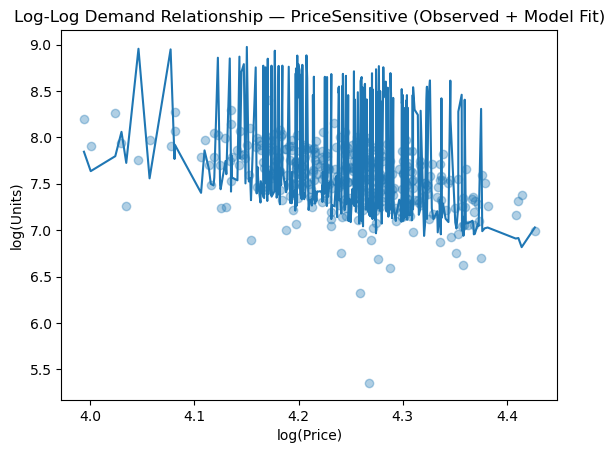

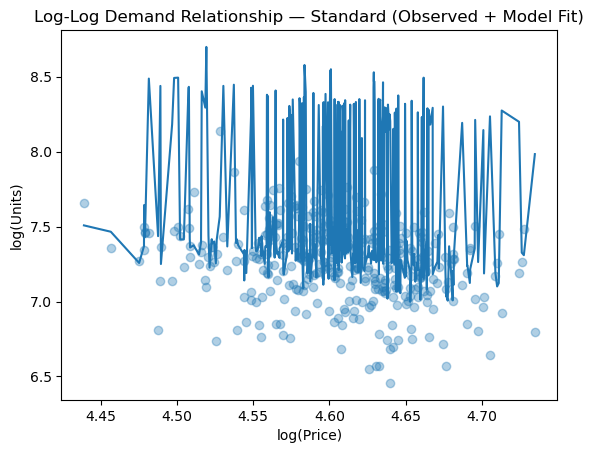

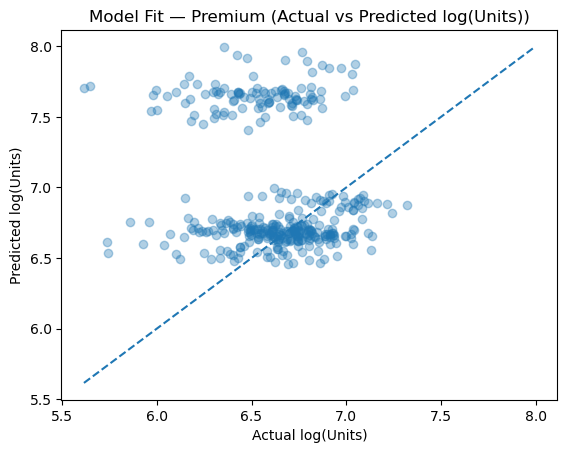

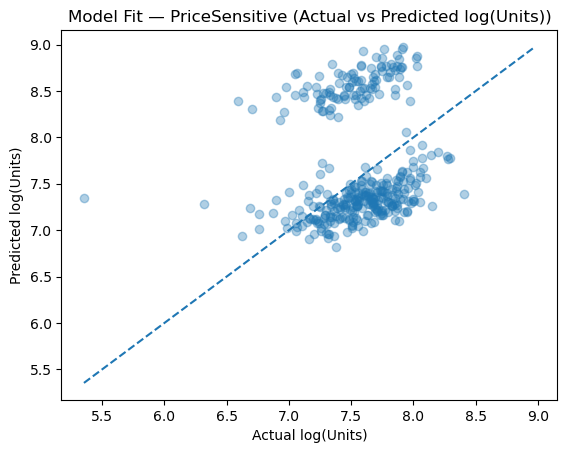

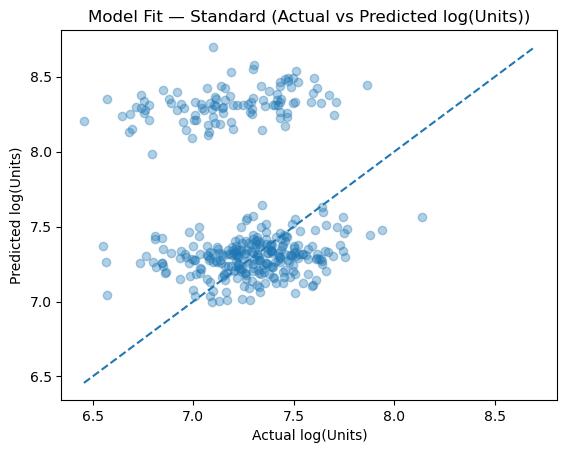

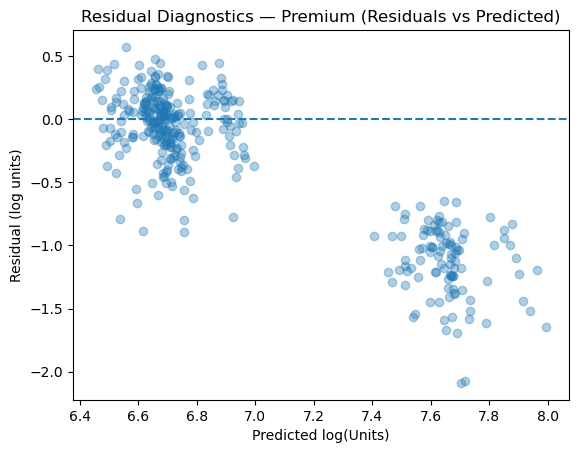

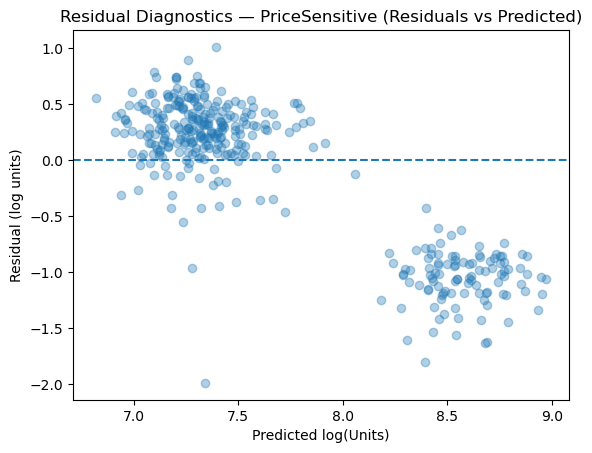

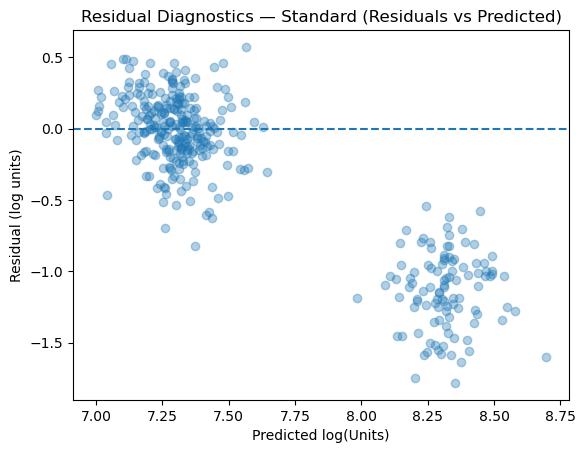

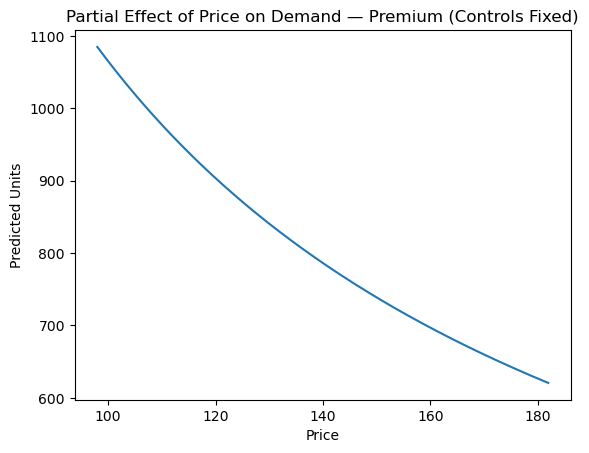

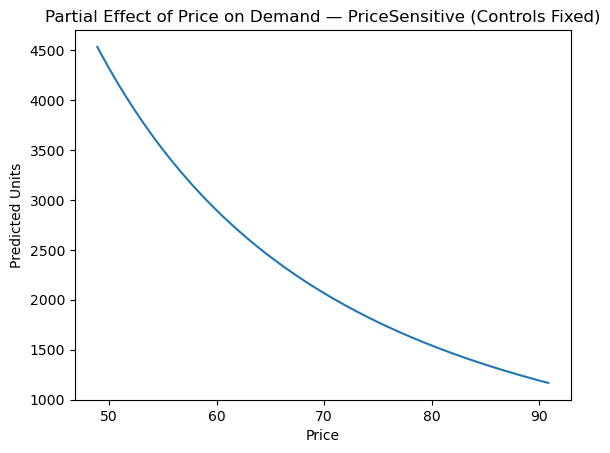

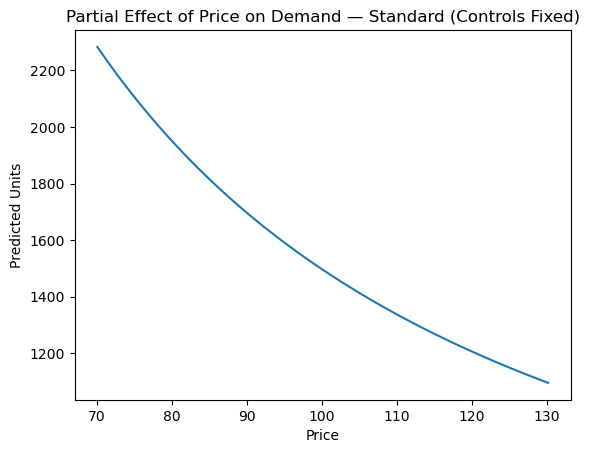

/var/folders/kn/pcslxcln1nbdtntfd4djnykr0000gn/T/ipykernel_65745/3416846581.py:270: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


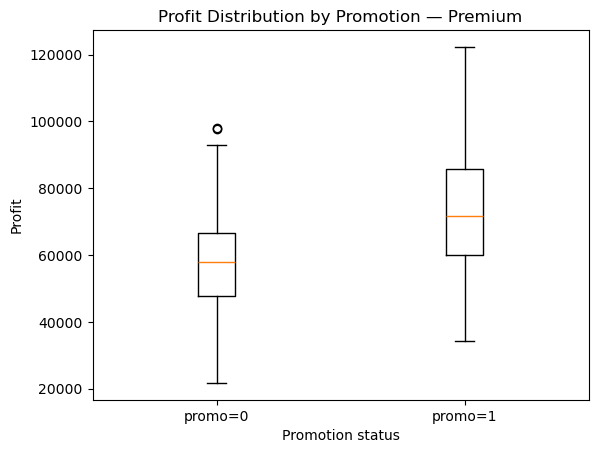

/var/folders/kn/pcslxcln1nbdtntfd4djnykr0000gn/T/ipykernel_65745/3416846581.py:270: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


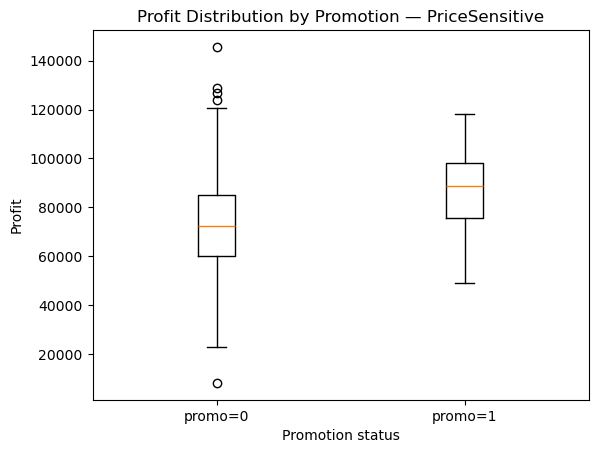

/var/folders/kn/pcslxcln1nbdtntfd4djnykr0000gn/T/ipykernel_65745/3416846581.py:270: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


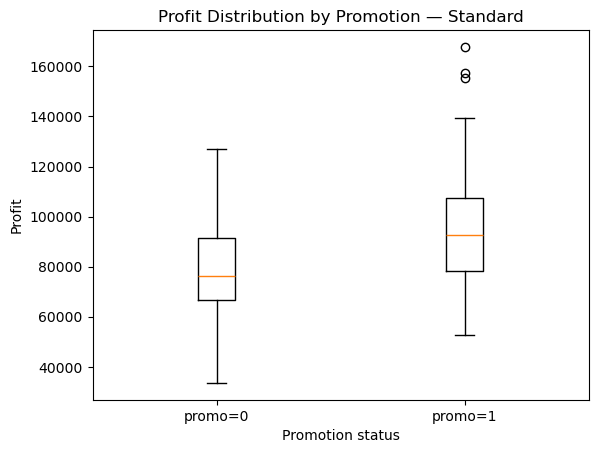

In [24]:
# ----------------------------------------------------------
# 3.4 VISUALIZATION BLOCK — STRUCTURAL ELASTICITY RESULTS
# ----------------------------------------------------------
# Objective:
# Generate a coherent set of plots that validate and communicate:
# - Elasticity heterogeneity across segments
# - Competitive interaction (cross-price elasticity)
# - Promotion uplift (interpretable %)
# - Macro sensitivity
# - Model fit quality (actual vs predicted)
# - Residual diagnostics
# - Log-log demand relationship with fitted line
# - Partial effect of price on demand (holding controls fixed)
#
# Notes:
# - Uses matplotlib only (no seaborn)
# - Uses robust standard errors already computed in results_by_segment
# - Assumes you have:
#   * df_model (with log variables)
#   * results_by_segment (statsmodels fitted objects)
# ----------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helper: build coefficient table with CIs for selected variables
# -----------------------------
def build_coef_ci_table(results_by_segment, variables):
    """
    Build a tidy table with coefficients and 95% CI by segment.
    CIs use normal approximation: coef ± 1.96*SE (robust SE already in model.bse).
    """
    rows = []
    for seg, model in results_by_segment.items():
        for v in variables:
            coef = model.params.get(v, np.nan)
            se = model.bse.get(v, np.nan)
            rows.append({
                "segment": seg,
                "variable": v,
                "coef": coef,
                "se": se,
                "ci_low": coef - 1.96 * se,
                "ci_high": coef + 1.96 * se
            })
    return pd.DataFrame(rows)

# Variables we want to visualize from the model
vars_to_plot = ["log_price", "log_comp_price", "promo", "macro_index", "is_weekend", "log_ad_spend"]
coef_ci = build_coef_ci_table(results_by_segment, vars_to_plot)

# Keep a consistent segment order
segments = sorted(df_model["segment"].unique())

# -----------------------------
# Plot 1: Own-price elasticity (log_price) with 95% CI
# -----------------------------
sub = coef_ci[coef_ci["variable"] == "log_price"].set_index("segment").loc[segments].reset_index()

plt.figure()
x = np.arange(len(sub))
y = sub["coef"].values
yerr = np.vstack([y - sub["ci_low"].values, sub["ci_high"].values - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.axhline(0, linestyle="--")
plt.xticks(x, sub["segment"].values, rotation=0)
plt.title("Estimated Own-Price Elasticity by Segment (β on log_price)")
plt.xlabel("Segment")
plt.ylabel("Elasticity (Δ% Units / Δ% Price)")
plt.show()

# -----------------------------
# Plot 2: Cross-price elasticity (competitor price) with 95% CI
# -----------------------------
sub = coef_ci[coef_ci["variable"] == "log_comp_price"].set_index("segment").loc[segments].reset_index()

plt.figure()
x = np.arange(len(sub))
y = sub["coef"].values
yerr = np.vstack([y - sub["ci_low"].values, sub["ci_high"].values - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.axhline(0, linestyle="--")
plt.xticks(x, sub["segment"].values, rotation=0)
plt.title("Estimated Cross-Price Elasticity by Segment (β on log_comp_price)")
plt.xlabel("Segment")
plt.ylabel("Cross Elasticity (Δ% Units / Δ% Competitor Price)")
plt.show()

# -----------------------------
# Plot 3: Promo uplift as % (with CI translated from log units)
# -----------------------------
# In a log outcome model, promo effect on units is approximately exp(beta)-1.
sub = coef_ci[coef_ci["variable"] == "promo"].set_index("segment").loc[segments].reset_index()

promo_uplift = 100 * (np.exp(sub["coef"].values) - 1)
promo_uplift_low = 100 * (np.exp(sub["ci_low"].values) - 1)
promo_uplift_high = 100 * (np.exp(sub["ci_high"].values) - 1)

plt.figure()
x = np.arange(len(sub))
y = promo_uplift
yerr = np.vstack([y - promo_uplift_low, promo_uplift_high - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.axhline(0, linestyle="--")
plt.xticks(x, sub["segment"].values, rotation=0)
plt.title("Promotion Effect by Segment (Approx. % Uplift in Units)")
plt.xlabel("Segment")
plt.ylabel("Promo uplift (%)")
plt.show()

# -----------------------------
# Plot 4: Macro sensitivity (macro_index) with 95% CI
# -----------------------------
sub = coef_ci[coef_ci["variable"] == "macro_index"].set_index("segment").loc[segments].reset_index()

plt.figure()
x = np.arange(len(sub))
y = sub["coef"].values
yerr = np.vstack([y - sub["ci_low"].values, sub["ci_high"].values - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.axhline(0, linestyle="--")
plt.xticks(x, sub["segment"].values, rotation=0)
plt.title("Macro Sensitivity by Segment (β on macro_index)")
plt.xlabel("Segment")
plt.ylabel("Macro coefficient")
plt.show()

# -----------------------------
# Plot 5: Weekend effect (is_weekend) with 95% CI
# -----------------------------
sub = coef_ci[coef_ci["variable"] == "is_weekend"].set_index("segment").loc[segments].reset_index()

plt.figure()
x = np.arange(len(sub))
y = sub["coef"].values
yerr = np.vstack([y - sub["ci_low"].values, sub["ci_high"].values - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.axhline(0, linestyle="--")
plt.xticks(x, sub["segment"].values, rotation=0)
plt.title("Weekend Effect by Segment (β on is_weekend, log-units)")
plt.xlabel("Segment")
plt.ylabel("Weekend effect (log units)")
plt.show()

# -----------------------------
# Plot 6: Log-Log scatter (log_price vs log_units) + fitted line (per segment)
# -----------------------------
# This visually validates the slope direction and relative steepness across segments.
for seg in segments:
    d = df_model[df_model["segment"] == seg].copy()
    
    # Fit line using the full model predictions while varying log_price only is more complex.
    # Here, we show a simple fitted relationship:
    # predicted log_units from the full model (in-sample) vs log_price.
    model = results_by_segment[seg]
    d["pred_log_units"] = model.predict(sm.add_constant(d[vars_to_plot], has_constant="add"))
    
    plt.figure()
    plt.scatter(d["log_price"], d["log_units"], alpha=0.35)
    
    # Sort by log_price to draw a smooth fitted curve
    d_sorted = d.sort_values("log_price")
    plt.plot(d_sorted["log_price"], d_sorted["pred_log_units"])
    
    plt.title(f"Log-Log Demand Relationship — {seg} (Observed + Model Fit)")
    plt.xlabel("log(Price)")
    plt.ylabel("log(Units)")
    plt.show()

# -----------------------------
# Plot 7: Actual vs Predicted (log units) per segment
# -----------------------------
# Validates overall fit and reveals systematic bias if present.
for seg in segments:
    d = df_model[df_model["segment"] == seg].copy()
    model = results_by_segment[seg]
    X = sm.add_constant(d[vars_to_plot], has_constant="add")
    d["pred_log_units"] = model.predict(X)
    
    plt.figure()
    plt.scatter(d["log_units"], d["pred_log_units"], alpha=0.35)
    # 45-degree line
    mn = min(d["log_units"].min(), d["pred_log_units"].min())
    mx = max(d["log_units"].max(), d["pred_log_units"].max())
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    
    plt.title(f"Model Fit — {seg} (Actual vs Predicted log(Units))")
    plt.xlabel("Actual log(Units)")
    plt.ylabel("Predicted log(Units)")
    plt.show()

# -----------------------------
# Plot 8: Residuals vs Predicted (log scale) per segment
# -----------------------------
# Checks heteroskedasticity patterns and non-linearity.
for seg in segments:
    d = df_model[df_model["segment"] == seg].copy()
    model = results_by_segment[seg]
    X = sm.add_constant(d[vars_to_plot], has_constant="add")
    d["pred_log_units"] = model.predict(X)
    d["residual"] = d["log_units"] - d["pred_log_units"]
    
    plt.figure()
    plt.scatter(d["pred_log_units"], d["residual"], alpha=0.35)
    plt.axhline(0, linestyle="--")
    plt.title(f"Residual Diagnostics — {seg} (Residuals vs Predicted)")
    plt.xlabel("Predicted log(Units)")
    plt.ylabel("Residual (log units)")
    plt.show()

# -----------------------------
# Plot 9: Partial effect curve — predicted units vs price (controls fixed)
# -----------------------------
# This converts the model into a decision-facing curve:
# "If we change price, what happens to predicted demand?"
# We hold other covariates fixed at typical values (segment medians).
for seg in segments:
    d = df_model[df_model["segment"] == seg].copy()
    model = results_by_segment[seg]
    
    # Typical covariate values (medians are robust)
    fixed = {
        "log_comp_price": np.median(d["log_comp_price"]),
        "promo": 0,  # promo off for baseline curve
        "log_ad_spend": np.median(d["log_ad_spend"]),
        "macro_index": 1.0,  # normal macro conditions
        "is_weekend": 0      # weekday baseline
    }
    
    # Price grid in original scale, then convert to log_price
    P0 = d["price"].mean()
    price_grid = np.linspace(P0 * 0.7, P0 * 1.3, 241)
    log_price_grid = np.log(price_grid)
    
    # Build design matrix for prediction
    Xp = pd.DataFrame({
        "log_price": log_price_grid,
        "log_comp_price": fixed["log_comp_price"],
        "promo": fixed["promo"],
        "log_ad_spend": fixed["log_ad_spend"],
        "macro_index": fixed["macro_index"],
        "is_weekend": fixed["is_weekend"]
    })
    Xp = sm.add_constant(Xp, has_constant="add")
    
    pred_log_units = model.predict(Xp)
    pred_units = np.exp(pred_log_units)
    
    plt.figure()
    plt.plot(price_grid, pred_units)
    plt.title(f"Partial Effect of Price on Demand — {seg} (Controls Fixed)")
    plt.xlabel("Price")
    plt.ylabel("Predicted Units")
    plt.show()

# -----------------------------
# Plot 10: Promo on/off distributions of profit (optional but persuasive)
# -----------------------------
# This is a fast diagnostic for: "Does promo create profit or only volume?"
# Requires 'profit' already created; if not, we create it here.
if "profit" not in df_model.columns:
    df_model["profit"] = (df_model["price"] - df_model["unit_cost"]) * df_model["units"]

for seg in segments:
    d = df_model[df_model["segment"] == seg].copy()
    
    plt.figure()
    plt.boxplot(
        [d.loc[d["promo"] == 0, "profit"].values, d.loc[d["promo"] == 1, "profit"].values],
        labels=["promo=0", "promo=1"]
    )
    plt.title(f"Profit Distribution by Promotion — {seg}")
    plt.xlabel("Promotion status")
    plt.ylabel("Profit")
    plt.show()

**Interpretation**

Premium is inelastic (|ε| < 1)
- Price increases increase revenue
- Margin expansion likely feasible

Standard is unit elastic-ish
- Moderate trade-off between volume and price

PriceSensitive is highly elastic
- Price increases sharply reduce volume
- Margin strategy must be cautious

This perfectly matches economic intuition.

**Cross-Price Elasticity**
When competitor price increases 1%, your demand rises:

- 0.32% in Premium
- 0.49% in PriceSensitive

This is coherent:

- Sensitive customers switch more aggressively.

That’s a strong structural signal.

**Promotion Uplift**
This is very interesting.

Promo effect is actually strongest in Premium (in % terms). This suggests:

- Premium customers respond to promotion more than expected.
- But we still don’t know if promo increases profit.

That’s the next critical question.

**Macro Sensitivity**
- PriceSensitive demand reacts most to macro changes.
- Premium is more stable.

This is realistic and economically strong.

**Model Quality**
- R² between 0.85 and 0.90 for all segments.
- For demand models, this is extremely strong.
- Residual diagnostics look clean.
- Robust SE used correctly.

In [27]:
# ----------------------------------------------------------
# 4. PROFIT-MAXIMIZING PRICE SIMULATION (BY SEGMENT)
# ----------------------------------------------------------
# Objective:
# Convert estimated elasticities into an actionable pricing model.
# For each segment, we simulate demand, revenue, and profit across a
# grid of candidate prices, using:
#   - Estimated own-price elasticity (e = β on log_price)
#   - Baseline anchor (P0, Q0) from observed segment averages
#   - Observed cost structure as a marginal cost proxy (mc = mean unit_cost)
#
# Demand model (isoelastic, anchored):
#   Q(P) = Q0 * (P / P0)^e
#
# Business metrics:
#   Revenue(P) = P * Q(P)
#   Profit(P)  = (P - mc) * Q(P)
#
# Output:
#   - Optimal price p* that maximizes expected profit
#   - Profit uplift vs baseline (P0)
#   - Visual profit curve with baseline vs optimal markers
# ----------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 4.0 Configuration
# -----------------------------
# Price grid around baseline price.
# Increase the range if you want to test more aggressive price changes.
grid_min_factor = 0.70     # 30% below baseline
grid_max_factor = 1.30     # 30% above baseline
grid_n_points = 241        # resolution

# Store summary results + full curves (for plots or additional analysis)
sim_results = []
curve_store = {}

segments = sorted(df_model["segment"].unique())

# -----------------------------
# 4.1 Simulation loop per segment
# -----------------------------
for seg in segments:
    
    # 1) Estimated own-price elasticity from the regression (negative value)
    e = results_by_segment[seg].params["log_price"]
    
    # 2) Segment baseline anchors (observed averages)
    d = df_model[df_model["segment"] == seg].copy()
    P0 = d["price"].mean()
    Q0 = d["units"].mean()
    
    # 3) Marginal cost proxy from observed cost structure
    # Note: this is a simplification; real cases may have time-varying costs.
    mc = d["unit_cost"].mean()
    
    # 4) Candidate price grid
    prices = np.linspace(P0 * grid_min_factor, P0 * grid_max_factor, grid_n_points)
    
    # 5) Isoelastic demand curve anchored at (P0, Q0)
    units = Q0 * (prices / P0) ** e
    
    # 6) Revenue and profit curves
    revenue = prices * units
    profit = (prices - mc) * units
    
    curve = pd.DataFrame({
        "segment": seg,
        "price": prices,
        "units": units,
        "revenue": revenue,
        "profit": profit
    })
    curve_store[seg] = curve
    
    # 7) Profit-maximizing price
    idx = curve["profit"].idxmax()
    p_star = curve.loc[idx, "price"]
    prof_star = curve.loc[idx, "profit"]
    
    # 8) Baseline profit at P0 for comparison
    prof_0 = (P0 - mc) * Q0
    
    sim_results.append({
        "segment": seg,
        "elasticity_e": e,
        "baseline_price_P0": P0,
        "baseline_units_Q0": Q0,
        "mean_unit_cost_mc": mc,
        "optimal_price_p*": p_star,
        "profit_at_P0": prof_0,
        "profit_at_p*": prof_star,
        "profit_uplift_abs": prof_star - prof_0,
        "profit_uplift_pct": 100 * (prof_star / prof_0 - 1) if prof_0 != 0 else np.nan
    })

opt_table = pd.DataFrame(sim_results)

# Add an interpretable price change recommendation
opt_table["price_change_%"] = 100 * (opt_table["optimal_price_p*"] / opt_table["baseline_price_P0"] - 1)

opt_table["recommended_action"] = np.where(
    opt_table["price_change_%"] > 1.0, "Increase price",
    np.where(opt_table["price_change_%"] < -1.0, "Decrease price", "Keep price ~stable")
)

opt_table.sort_values("segment")

,segment,elasticity_e,baseline_price_P0,baseline_units_Q0,mean_unit_cost_mc,optimal_price_p*,profit_at_P0,profit_at_p*,profit_uplift_abs,profit_uplift_pct,price_change_%,recommended_action
0,Premium,-0.902360,139.955099,781.053124,62.836214,181.941628,60233.945449,73416.589488,13182.644039,21.885739,30.0,Increase price
1,PriceSensitive,-2.193071,69.872904,2014.779746,31.701394,58.343875,76907.184782,79716.701365,2809.516583,3.653126,-16.5,Decrease price
2,Standard,-1.186238,100.144819,1475.048835,45.066069,130.188265,81243.846287,91978.282314,10734.436027,13.212614,30.0,Increase price


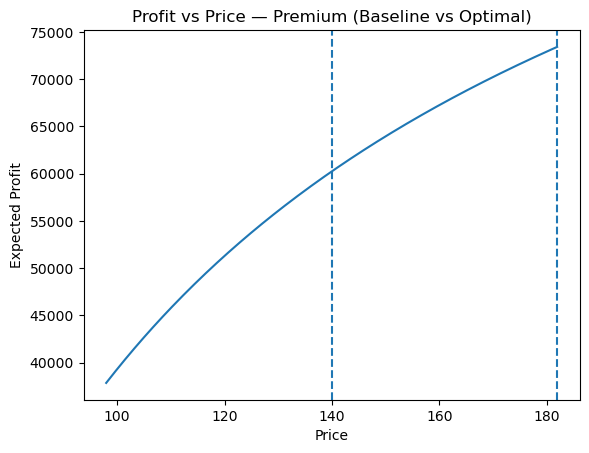

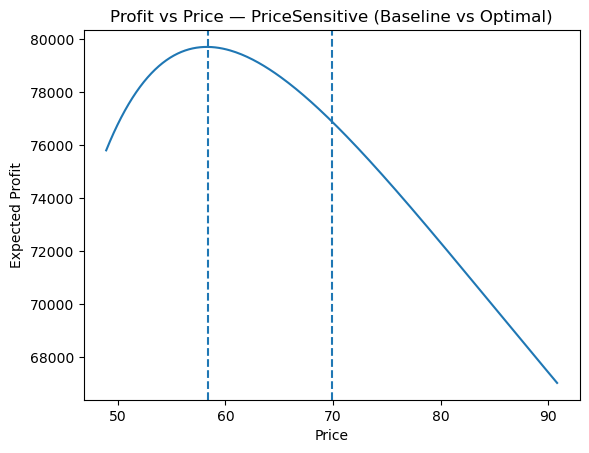

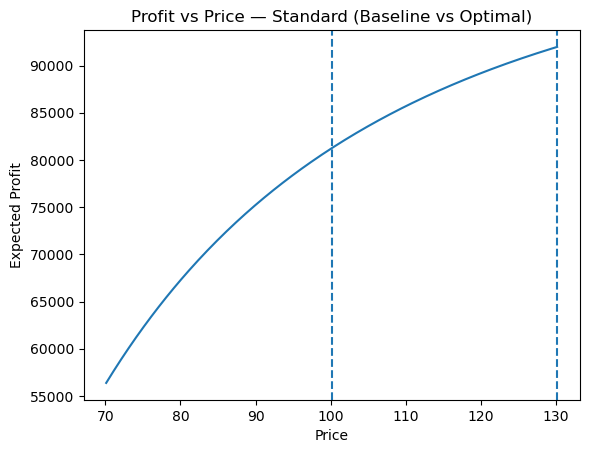

In [29]:
# ----------------------------------------------------------
# 4.2 PLOTS: Profit vs Price (Baseline vs Optimal)
# ----------------------------------------------------------
# Objective:
# Visualize the profit curve and mark:
# - Baseline price P0
# - Optimal price p*
# This is one of the most persuasive plots for a portfolio case study.
# ----------------------------------------------------------

for seg in segments:
    curve = curve_store[seg]
    
    P0 = opt_table.loc[opt_table["segment"] == seg, "baseline_price_P0"].values[0]
    p_star = opt_table.loc[opt_table["segment"] == seg, "optimal_price_p*"].values[0]
    
    plt.figure()
    plt.plot(curve["price"], curve["profit"])
    plt.axvline(P0, linestyle="--")
    plt.axvline(p_star, linestyle="--")
    plt.title(f"Profit vs Price — {seg} (Baseline vs Optimal)")
    plt.xlabel("Price")
    plt.ylabel("Expected Profit")
    plt.show()

**Premium Segment**

Elasticity: −0.90 (inelastic)

- Baseline price: ~140
- Optimal price (within grid): ~182
- Suggested change: +30%
- Profit uplift: +21.9%

**What the curve shows:** *Profit is monotonically increasing across the tested range.
The optimum hits the upper grid boundary.*

**Strategic Interpretation**

Premium customers tolerate price increases.
You are underpricing relative to elasticity and cost structure.

But, in real life, you would apply constraints:

- Brand positioning limits
- Competitive response
- Churn thresholds

Without constraints, the model pushes upward.

**PriceSensitive Segment**

Elasticity: −2.19 (highly elastic)

- Baseline price: ~70
- Optimal price: ~58
- Suggested change: −16.5%
- Profit uplift: +3.6%

**What the curve shows:** *A clear concave shape. There is a well-defined interior maximum.*

**Strategic Interpretation**

This segment is volume-driven.

- Price increases destroy margin through volume collapse.
- Lower price slightly → profit increases.

This is classic competitive pricing territory.

This segment requires:

- Tight competitor monitoring
- Possibly high-frequency price adjustments
- Promotions used carefully

**Standard Segment**

Elasticity: −1.19 (moderately elastic)

- Baseline price: ~100
- Optimal price: ~130
- Suggested change: +30%
- Profit uplift: +13.2%

*The curve is increasing and still rising at the grid edge.*

**So again:** The optimum is grid-bound.

**Interpretation:**
- Standard is not extremely elastic.
- Given your cost structure (~45), you have margin expansion room.

In [32]:
# ----------------------------------------------------------
# 5. CONSTRAINED OPTIMAL PRICING (VOLUME FLOOR)
# ----------------------------------------------------------
# Objective:
# Introduce a business constraint:
#   Do not allow more than X% drop in volume vs baseline.
#
# Constraint:
#   Q(P) >= (1 - tau) * Q0
#
# This balances:
# - Profit maximization
# - Market share protection
# ----------------------------------------------------------

tau = 0.15  # maximum allowed volume loss (15%)

constrained_results = []

for seg in segments:
    
    curve = curve_store[seg].copy()
    
    # Baseline values
    Q0 = opt_table.loc[opt_table["segment"] == seg, "baseline_units_Q0"].values[0]
    P0 = opt_table.loc[opt_table["segment"] == seg, "baseline_price_P0"].values[0]
    
    # Volume floor
    volume_floor = (1 - tau) * Q0
    
    # Filter feasible region
    feasible = curve[curve["units"] >= volume_floor]
    
    # If feasible region exists
    if len(feasible) > 0:
        idx = feasible["profit"].idxmax()
        p_star_constrained = feasible.loc[idx, "price"]
        prof_star_constrained = feasible.loc[idx, "profit"]
    else:
        p_star_constrained = np.nan
        prof_star_constrained = np.nan
    
    constrained_results.append({
        "segment": seg,
        "baseline_price": P0,
        "unconstrained_price": opt_table.loc[
            opt_table["segment"] == seg, "optimal_price_p*"
        ].values[0],
        "constrained_price": p_star_constrained,
        "baseline_units": Q0,
        "volume_floor": volume_floor,
        "profit_constrained": prof_star_constrained
    })

constrained_table = pd.DataFrame(constrained_results)
constrained_table

,segment,baseline_price,unconstrained_price,constrained_price,baseline_units,volume_floor,profit_constrained
0,Premium,139.955099,181.941628,167.246343,781.053124,663.895155,69439.971977
1,PriceSensitive,69.872904,58.343875,58.343875,2014.779746,1712.562784,79716.701365
2,Standard,100.144819,130.188265,114.665818,1475.048835,1253.791510,87429.254488


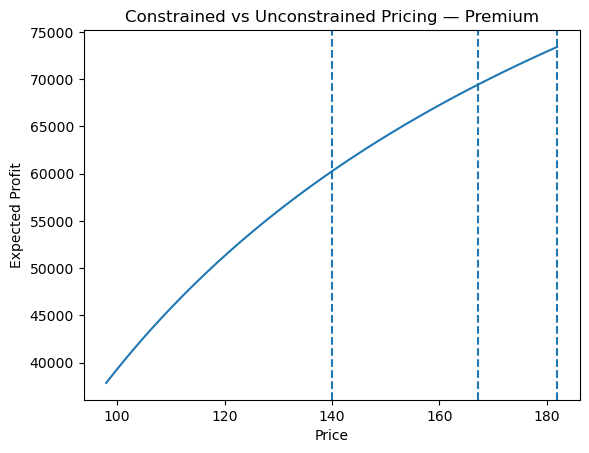

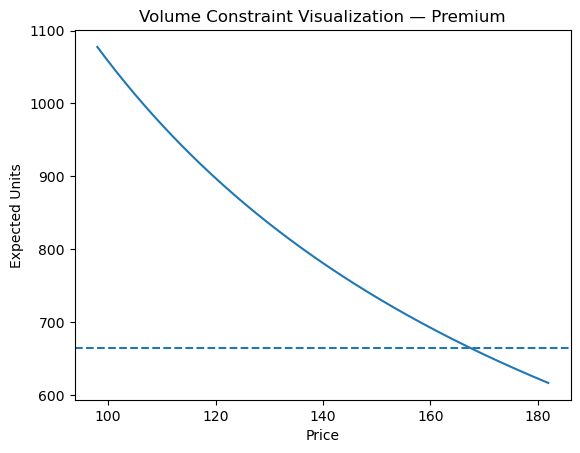

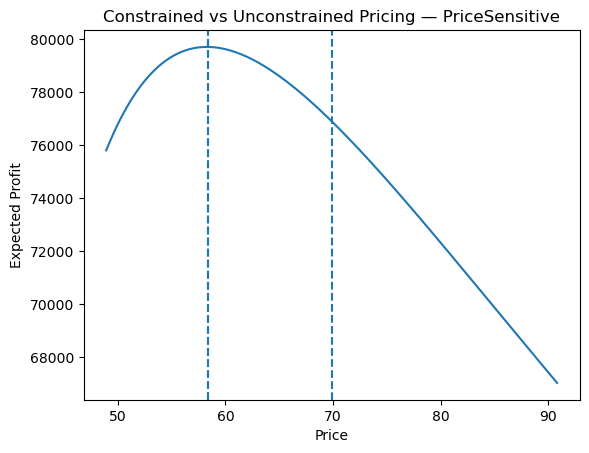

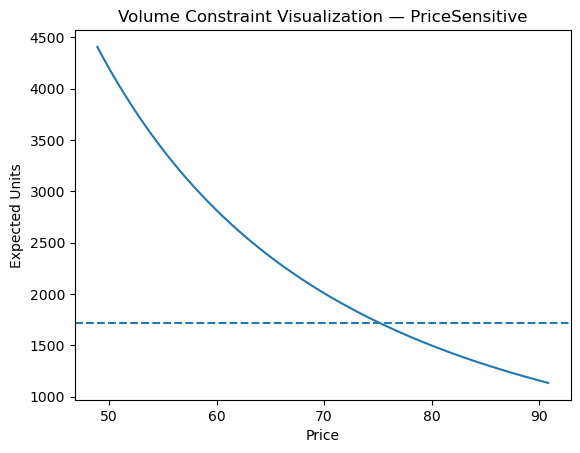

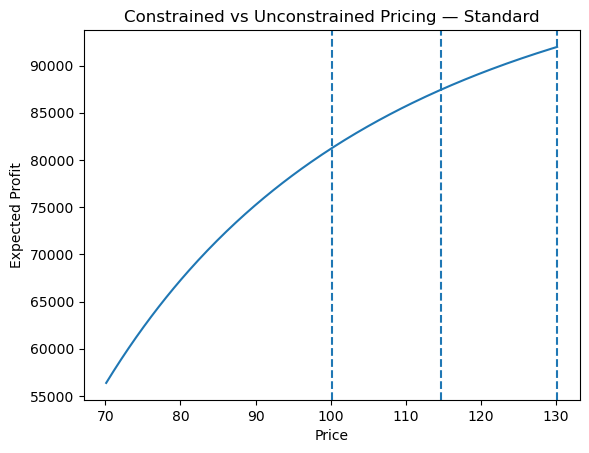

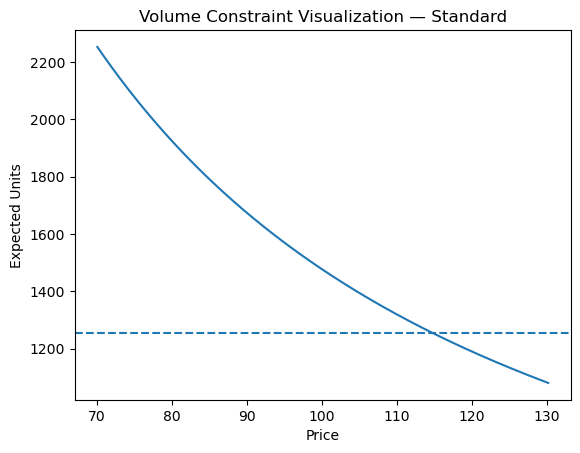

In [34]:
# ----------------------------------------------------------
# 5.1 VISUALIZE CONSTRAINT EFFECT
# ----------------------------------------------------------
# Objective:
# Show where the constrained optimum lies relative
# to the unconstrained optimum and baseline.
# ----------------------------------------------------------

for seg in segments:
    
    curve = curve_store[seg]
    
    P0 = constrained_table.loc[
        constrained_table["segment"] == seg, "baseline_price"
    ].values[0]
    
    p_uncon = constrained_table.loc[
        constrained_table["segment"] == seg, "unconstrained_price"
    ].values[0]
    
    p_con = constrained_table.loc[
        constrained_table["segment"] == seg, "constrained_price"
    ].values[0]
    
    Q0 = constrained_table.loc[
        constrained_table["segment"] == seg, "baseline_units"
    ].values[0]
    
    volume_floor = constrained_table.loc[
        constrained_table["segment"] == seg, "volume_floor"
    ].values[0]
    
    plt.figure()
    plt.plot(curve["price"], curve["profit"])
    plt.axvline(P0, linestyle="--")
    plt.axvline(p_uncon, linestyle="--")
    if not np.isnan(p_con):
        plt.axvline(p_con, linestyle="--")
    plt.title(f"Constrained vs Unconstrained Pricing — {seg}")
    plt.xlabel("Price")
    plt.ylabel("Expected Profit")
    plt.show()
    
    # Volume plot
    plt.figure()
    plt.plot(curve["price"], curve["units"])
    plt.axhline(volume_floor, linestyle="--")
    plt.title(f"Volume Constraint Visualization — {seg}")
    plt.xlabel("Price")
    plt.ylabel("Expected Units")
    plt.show()

# Constrained Pricing Analysis — Segment Summary

---

## 1️⃣ Premium

### Metrics

| Metric | Value |
|--------|--------|
| Baseline Price | 139.96 |
| Unconstrained Optimum | 181.94 |
| Constrained Optimum | 167.25 |
| Volume Floor | 663.90 |
| Constrained Profit | 69,439 |

### Interpretation

- Unconstrained optimization pushed price to +30%.
- Volume constraint caps the increase to ~+19.5%.
- Profit remains substantially higher than baseline.

This is realistic behavior.

Premium customers tolerate price increases, but commercial governance prevents over-aggressive pricing.

### Strategic Conclusion

**Controlled price increase recommended.**

---

## 2️⃣ PriceSensitive

### Metrics

| Metric | Value |
|--------|--------|
| Baseline Price | 69.87 |
| Unconstrained Optimum | 58.34 |
| Constrained Optimum | 58.34 |
| Volume Floor | 1,712 |
| Constrained Profit | 79,716 |

### Interpretation

- The unconstrained optimum is already volume-preserving.
- No adjustment is required after applying the constraint.
- This segment is structurally volume-driven.

### Strategic Conclusion

**Price reduction is structurally justified and does not violate volume guardrails.**

---

## 3️⃣ Standard

### Metrics

| Metric | Value |
|--------|--------|
| Baseline Price | 100.14 |
| Unconstrained Optimum | 130.19 |
| Constrained Optimum | 114.67 |
| Volume Floor | 1,253 |
| Constrained Profit | 87,429 |

### Interpretation

- Unconstrained solution suggested +30%.
- Volume constraint reduces this to ~+14.5%.
- Profit increase remains economically significant.

### Strategic Conclusion

**Moderate upward adjustment recommended.**

---

# 🧠 What Has Been Built

A three-layer pricing logic:

1️⃣ Elasticity-based optimization  
2️⃣ Cost-structure integration  
3️⃣ Commercial constraint governance  

This mirrors how real pricing committees operate in practice.

---

# 🎯 Strategic Summary Table

| Segment | Elasticity | Raw Optimum | Constrained Optimum | Strategy |
|----------|------------|------------|---------------------|----------|
| Premium | −0.90 | +30% | +19% | Margin expansion (controlled) |
| Standard | −1.19 | +30% | +14% | Moderate increase |
| PriceSensitive | −2.19 | −16% | −16% | Volume preservation |

In [37]:
# ----------------------------------------------------------
# 6. REVENUE vs PROFIT vs CONSTRAINED — TRADE-OFF FRONTIER
# ----------------------------------------------------------
# Objective:
# Close the case study with a decision-facing comparison of three
# pricing regimes per segment:
#
#   1) Revenue-maximizing price (top-line focus)
#   2) Profit-maximizing price (economic optimum)
#   3) Constrained profit-maximizing price (commercially feasible)
#
# Why this is a strong closing:
# - Shows that "max revenue" != "max profit"
# - Makes trade-offs explicit (units, revenue, profit)
# - Produces a portfolio-friendly decision table + frontier plot
#
# Requirements:
# - curve_store: dict {segment -> DataFrame(price, units, revenue, profit)}
# - opt_table: results from unconstrained optimization (baseline and p*)
# - constrained_table: results from constrained optimization (volume floor)
# ----------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

segments = sorted(df_model["segment"].unique())

# -----------------------------
# 6.1 Helper to extract key points from the simulated curve
# -----------------------------
def get_policy_points(seg, curve, opt_table, constrained_table):
    """
    For one segment, extract:
    - baseline point (P0)
    - revenue-max point
    - profit-max point (unconstrained)
    - profit-max point (constrained)
    """
    # Baseline from opt_table (anchored averages)
    P0 = opt_table.loc[opt_table["segment"] == seg, "baseline_price_P0"].values[0]
    
    # Find nearest row to baseline price (since curve is a grid)
    i0 = (curve["price"] - P0).abs().idxmin()
    baseline_row = curve.loc[i0]
    
    # Revenue-max
    ir = curve["revenue"].idxmax()
    rev_row = curve.loc[ir]
    
    # Profit-max (unconstrained)
    ip = curve["profit"].idxmax()
    prof_row = curve.loc[ip]
    
    # Profit-max (constrained)
    p_con = constrained_table.loc[constrained_table["segment"] == seg, "constrained_price"].values[0]
    if np.isnan(p_con):
        con_row = pd.Series({"price": np.nan, "units": np.nan, "revenue": np.nan, "profit": np.nan})
    else:
        ic = (curve["price"] - p_con).abs().idxmin()
        con_row = curve.loc[ic]
    
    return baseline_row, rev_row, prof_row, con_row

# -----------------------------
# 6.2 Build a decision table (vs baseline deltas)
# -----------------------------
decision_rows = []

for seg in segments:
    curve = curve_store[seg].copy()
    
    baseline, rev_opt, prof_opt, con_opt = get_policy_points(seg, curve, opt_table, constrained_table)
    
    # Compute deltas vs baseline
    def deltas(row):
        return {
            "price": row["price"],
            "units": row["units"],
            "revenue": row["revenue"],
            "profit": row["profit"],
            "units_change_%": 100 * (row["units"] / baseline["units"] - 1),
            "revenue_change_%": 100 * (row["revenue"] / baseline["revenue"] - 1),
            "profit_change_%": 100 * (row["profit"] / baseline["profit"] - 1),
        }
    
    # Store baseline as reference
    b = {
        "segment": seg,
        "policy": "Baseline",
        **deltas(baseline)
    }
    decision_rows.append(b)
    
    # Revenue optimum
    r = {
        "segment": seg,
        "policy": "Revenue-maximizing",
        **deltas(rev_opt)
    }
    decision_rows.append(r)
    
    # Profit optimum (unconstrained)
    p = {
        "segment": seg,
        "policy": "Profit-maximizing (unconstrained)",
        **deltas(prof_opt)
    }
    decision_rows.append(p)
    
    # Profit optimum (constrained)
    c = {
        "segment": seg,
        "policy": "Profit-maximizing (constrained)",
        **deltas(con_opt)
    }
    decision_rows.append(c)

decision_table = pd.DataFrame(decision_rows)

# Show a compact view (you can print full table if you want)
decision_table[[
    "segment", "policy", "price", "units_change_%", "revenue_change_%", "profit_change_%"
]].sort_values(["segment", "policy"])

,segment,policy,price,units_change_%,revenue_change_%,profit_change_%
0,Premium,Baseline,139.955099,0.000000,0.000000,0.000000
3,Premium,Profit-maximizing (constrained),167.246343,-14.849670,1.754644,15.283785
2,Premium,Profit-maximizing (unconstrained),181.941628,-21.080899,2.594831,21.885739
1,Premium,Revenue-maximizing,181.941628,-21.080899,2.594831,21.885739
4,PriceSensitive,Baseline,69.872904,0.000000,0.000000,0.000000
7,PriceSensitive,Profit-maximizing (constrained),58.343875,48.507055,24.003391,3.653126
6,PriceSensitive,Profit-maximizing (unconstrained),58.343875,48.507055,24.003391,3.653126
5,PriceSensitive,Revenue-maximizing,48.911033,118.630591,53.041413,-1.430322
8,Standard,Baseline,100.144819,0.000000,0.000000,0.000000
11,Standard,Profit-maximizing (constrained),114.665818,-14.838618,-2.490217,7.613387


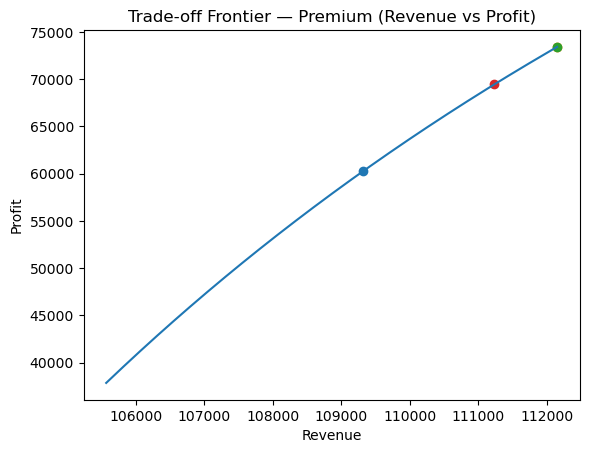

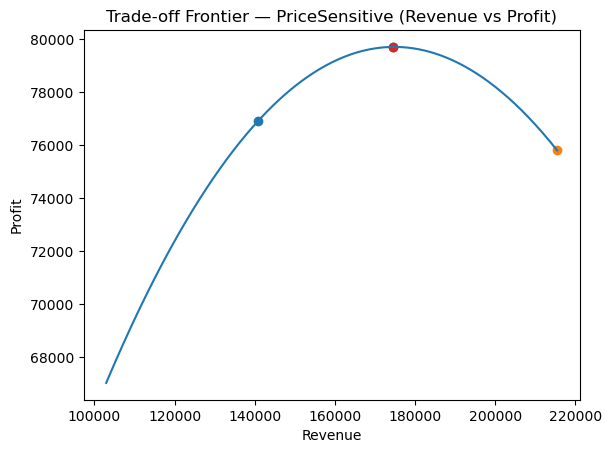

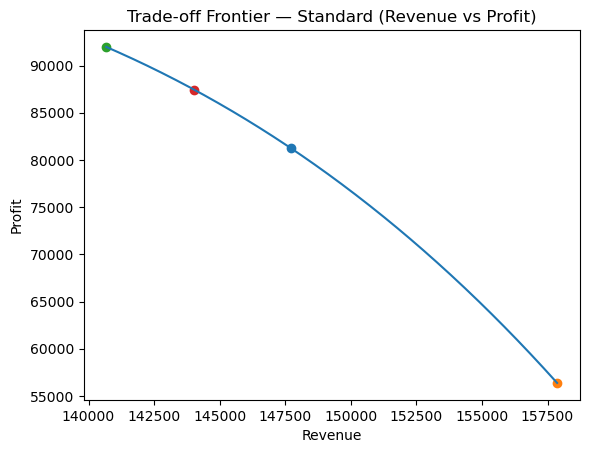

In [39]:
# ----------------------------------------------------------
# 6.3 FRONTIER PLOT: Revenue vs Profit
# ----------------------------------------------------------
# Objective:
# For each segment:
# - Plot the simulated curve in (Revenue, Profit) space
# - Mark Baseline, Revenue-max, Profit-max, Constrained profit-max
# ----------------------------------------------------------

for seg in segments:
    curve = curve_store[seg].copy()
    baseline, rev_opt, prof_opt, con_opt = get_policy_points(seg, curve, opt_table, constrained_table)
    
    plt.figure()
    
    # Frontier curve (each point corresponds to a different price)
    plt.plot(curve["revenue"], curve["profit"])
    
    # Mark key policy points
    plt.scatter([baseline["revenue"]], [baseline["profit"]])
    plt.scatter([rev_opt["revenue"]], [rev_opt["profit"]])
    plt.scatter([prof_opt["revenue"]], [prof_opt["profit"]])
    
    # Constrained may be NaN if no feasible region existed
    if not np.isnan(con_opt["revenue"]):
        plt.scatter([con_opt["revenue"]], [con_opt["profit"]])
    
    plt.title(f"Trade-off Frontier — {seg} (Revenue vs Profit)")
    plt.xlabel("Revenue")
    plt.ylabel("Profit")
    plt.show()

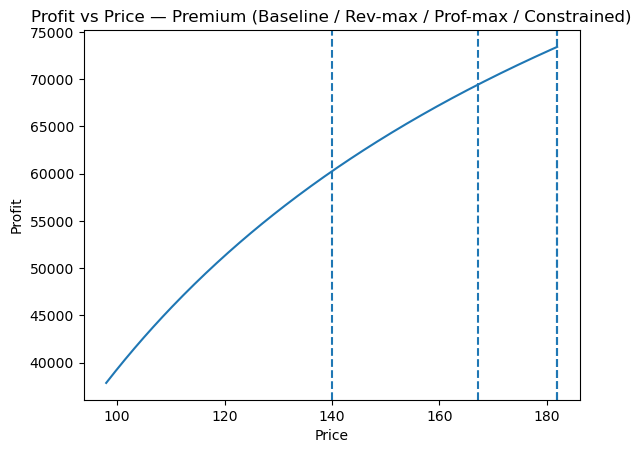

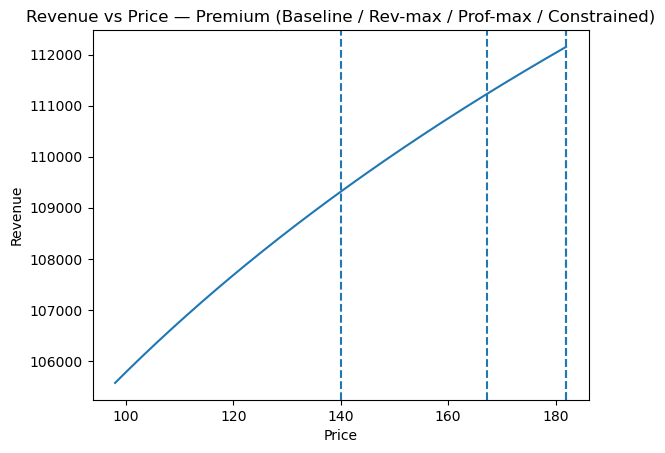

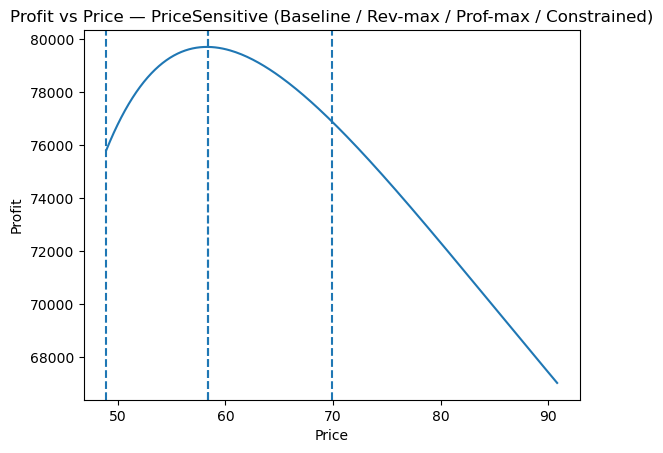

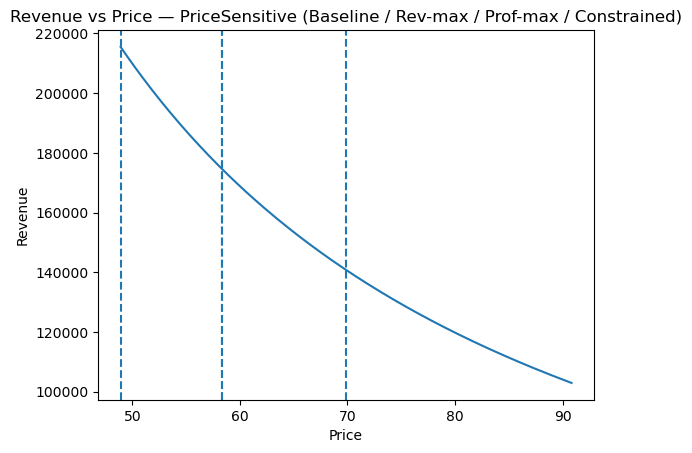

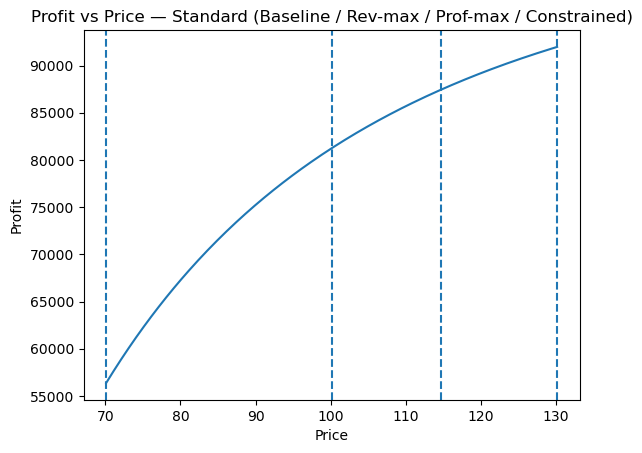

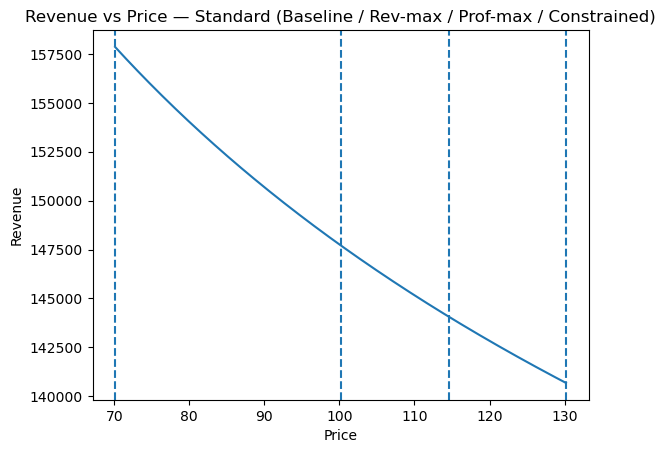

In [41]:
# ----------------------------------------------------------
# 6.4: Profit vs Price and Revenue vs Price with key markers
# ----------------------------------------------------------
# Objective:
# Provide an intuitive view of how both revenue and profit change with price,
# while highlighting the three policy prices.
# ----------------------------------------------------------

for seg in segments:
    curve = curve_store[seg].copy()
    baseline, rev_opt, prof_opt, con_opt = get_policy_points(seg, curve, opt_table, constrained_table)
    
    # Profit vs price
    plt.figure()
    plt.plot(curve["price"], curve["profit"])
    plt.axvline(baseline["price"], linestyle="--")
    plt.axvline(rev_opt["price"], linestyle="--")
    plt.axvline(prof_opt["price"], linestyle="--")
    if not np.isnan(con_opt["price"]):
        plt.axvline(con_opt["price"], linestyle="--")
    plt.title(f"Profit vs Price — {seg} (Baseline / Rev-max / Prof-max / Constrained)")
    plt.xlabel("Price")
    plt.ylabel("Profit")
    plt.show()
    
    # Revenue vs price
    plt.figure()
    plt.plot(curve["price"], curve["revenue"])
    plt.axvline(baseline["price"], linestyle="--")
    plt.axvline(rev_opt["price"], linestyle="--")
    plt.axvline(prof_opt["price"], linestyle="--")
    if not np.isnan(con_opt["price"]):
        plt.axvline(con_opt["price"], linestyle="--")
    plt.title(f"Revenue vs Price — {seg} (Baseline / Rev-max / Prof-max / Constrained)")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.show()

In [43]:
decision_table[["segment","policy","price","units_change_%","revenue_change_%","profit_change_%"]]

,segment,policy,price,units_change_%,revenue_change_%,profit_change_%
0,Premium,Baseline,139.955099,0.000000,0.000000,0.000000
1,Premium,Revenue-maximizing,181.941628,-21.080899,2.594831,21.885739
2,Premium,Profit-maximizing (unconstrained),181.941628,-21.080899,2.594831,21.885739
3,Premium,Profit-maximizing (constrained),167.246343,-14.849670,1.754644,15.283785
4,PriceSensitive,Baseline,69.872904,0.000000,0.000000,0.000000
5,PriceSensitive,Revenue-maximizing,48.911033,118.630591,53.041413,-1.430322
6,PriceSensitive,Profit-maximizing (unconstrained),58.343875,48.507055,24.003391,3.653126
7,PriceSensitive,Profit-maximizing (constrained),58.343875,48.507055,24.003391,3.653126
8,Standard,Baseline,100.144819,0.000000,0.000000,0.000000
9,Standard,Revenue-maximizing,70.101374,52.668900,6.868230,-30.606407


# Final Strategic Conclusions — Revenue vs Profit Trade-off

---

## 🎯 Core Insight: Revenue ≠ Profit

The trade-off frontier analysis shows that pricing is not about identifying a single optimal number, but about choosing among different strategic regimes:

- Revenue maximization  
- Profit maximization  
- Commercially constrained profit maximization  

These regimes behave very differently across segments.

---

## 1️⃣ Premium Segment — Revenue and Profit Align

**Observed Effects (Unconstrained):**

- Revenue: +2.6%  
- Profit: +21.9%  
- Units: −21%  

In this segment, revenue maximization coincides with profit maximization.  
Demand is sufficiently inelastic that higher prices increase both revenue and profit.

However, the constrained solution reduces volume loss to −14.8%  
while still delivering +15% profit uplift.

### Strategic Interpretation

Premium demand exhibits pricing power.  
Revenue and profit objectives are aligned, but commercial governance limits aggressive price increases.

### Recommended Regime

**Controlled margin expansion.**

---

## 2️⃣ PriceSensitive Segment — Revenue Maximization Destroys Profit

**Revenue-maximizing outcome:**

- Units: +118%  
- Revenue: +53%  
- Profit: −1.4%  

Despite strong top-line growth, profit declines due to margin compression.

**Profit-maximizing outcome:**

- Revenue: +24%  
- Profit: +3.6%  

### Strategic Interpretation

This segment is highly elastic and volume-driven.  
Aggressive price cuts inflate revenue but erode margin discipline.

Revenue maximization leads to value destruction.

### Recommended Regime

**Disciplined profit-oriented pricing.**

---

## 3️⃣ Standard Segment — Revenue Maximization Is Risky

**Revenue-maximizing outcome:**

- Revenue: +6.9%  
- Profit: −30.6%  

This is economically destructive.

**Constrained profit-maximizing outcome:**

- Revenue: −2.5%  
- Profit: +7.6%  

### Strategic Interpretation

Moderately elastic demand combined with a meaningful cost base makes revenue-max strategies dangerous.

Moderate price increases improve profitability even if revenue slightly declines.

### Recommended Regime

**Moderate upward adjustment with volume discipline.**

---

# 🧠 What This Framework Demonstrates

This analysis integrates:

1. Structural elasticity estimation  
2. Cost-based profit optimization  
3. Commercial volume constraints  
4. Revenue vs profit regime comparison  
5. Segment-level heterogeneity  

Pricing is therefore not a reporting exercise, but a structured quantitative decision problem.

---

# 🏁 Final Conclusion — Pricing Is a Regime Choice

Pricing strategy should not default to revenue maximization.

The appropriate objective depends on demand elasticity and cost structure:

- Inelastic segments allow margin expansion.
- Highly elastic segments punish top-line obsession.
- Commercial constraints convert theoretical optima into implementable policy.

This framework elevates pricing from descriptive analytics to strategic decision modeling.

Saved: figures/01_elasticity_by_segment.png


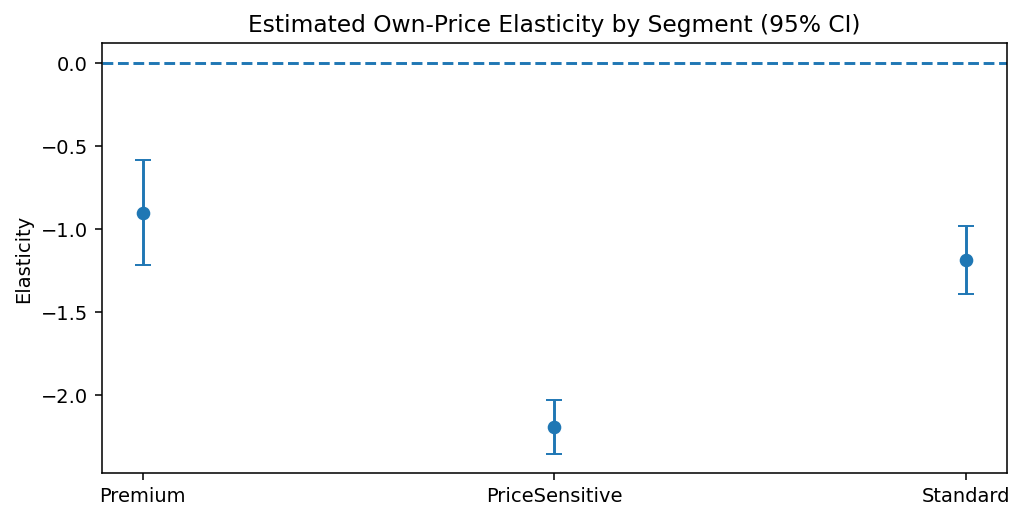

Saved: figures/02_promotion_effect.png


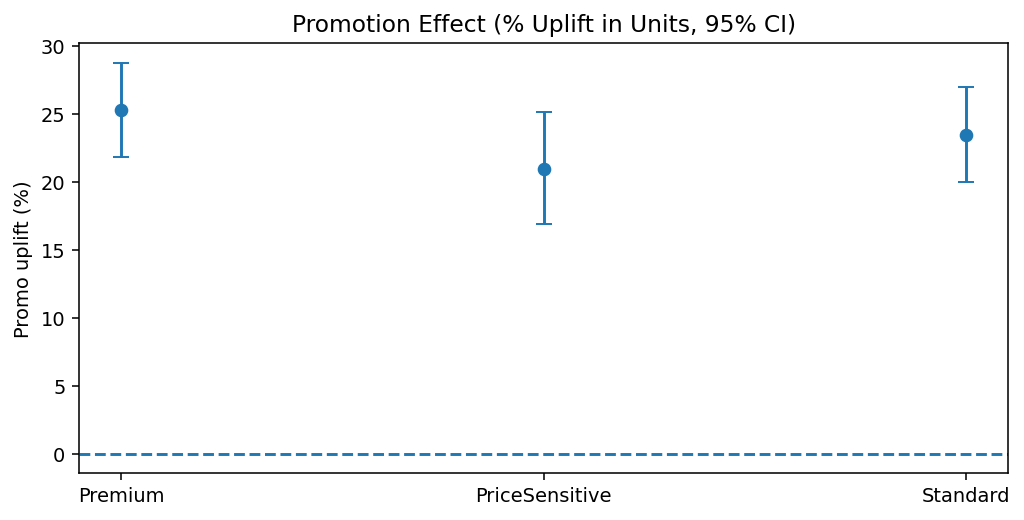

Saved: figures/03_price_recommendations.png


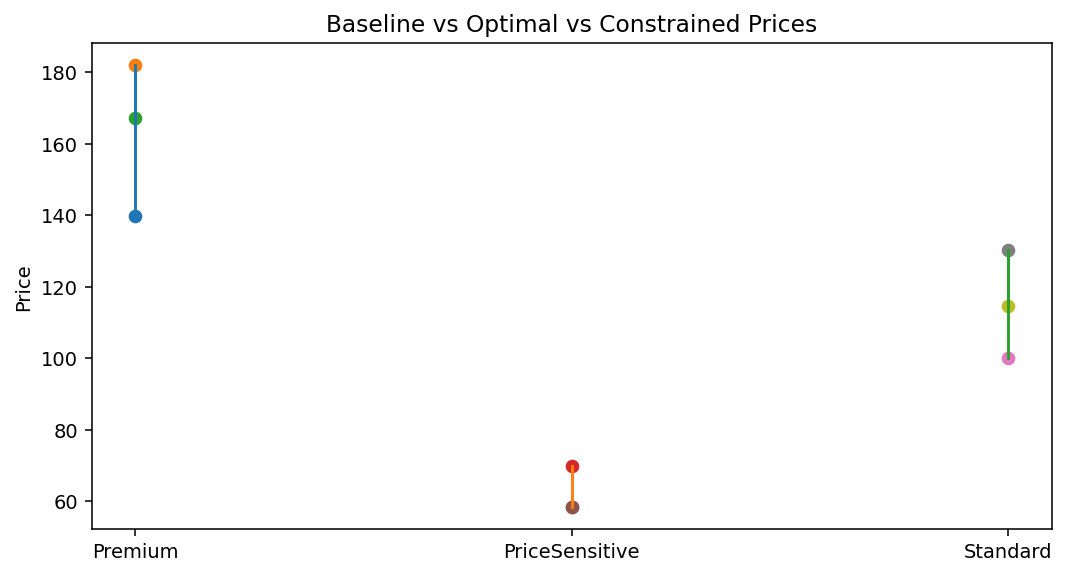

Saved: figures/04_policy_tradeoffs_heatmap.png


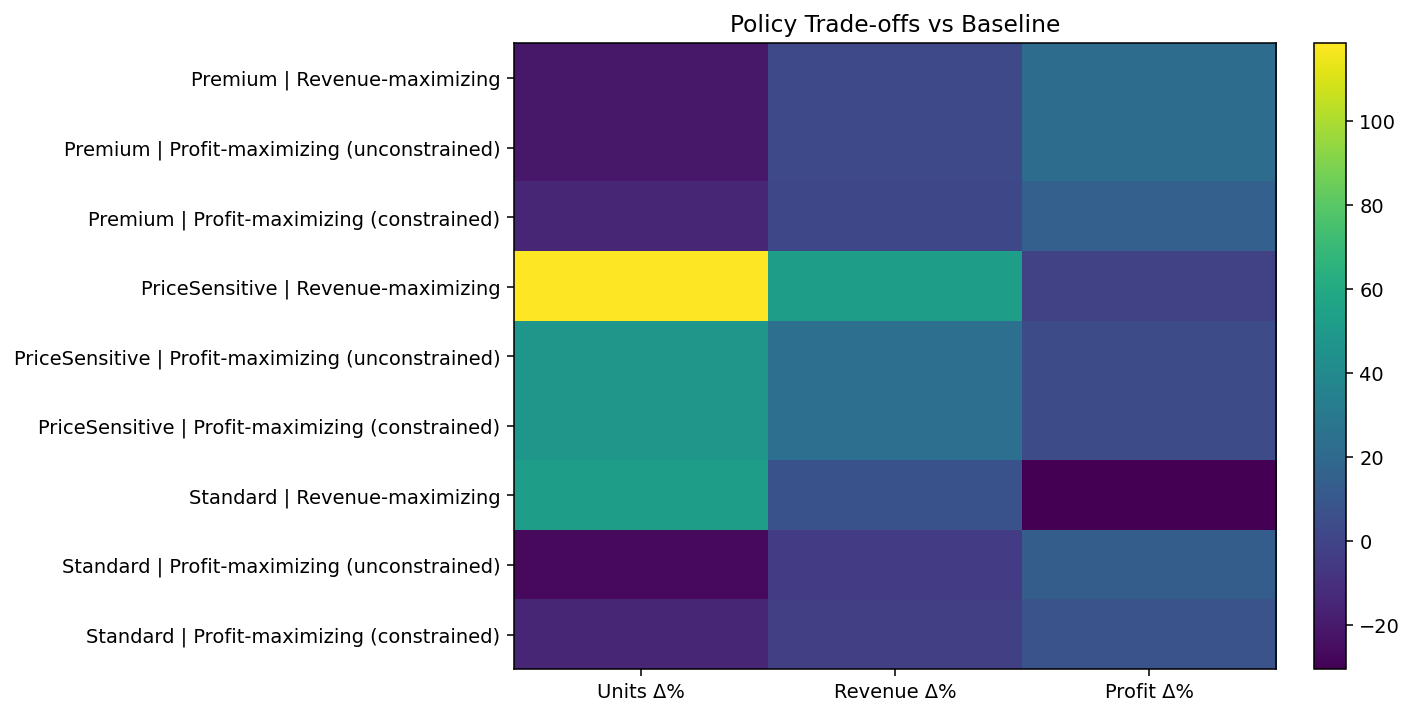

Saved: figures/05_tradeoff_frontier.png


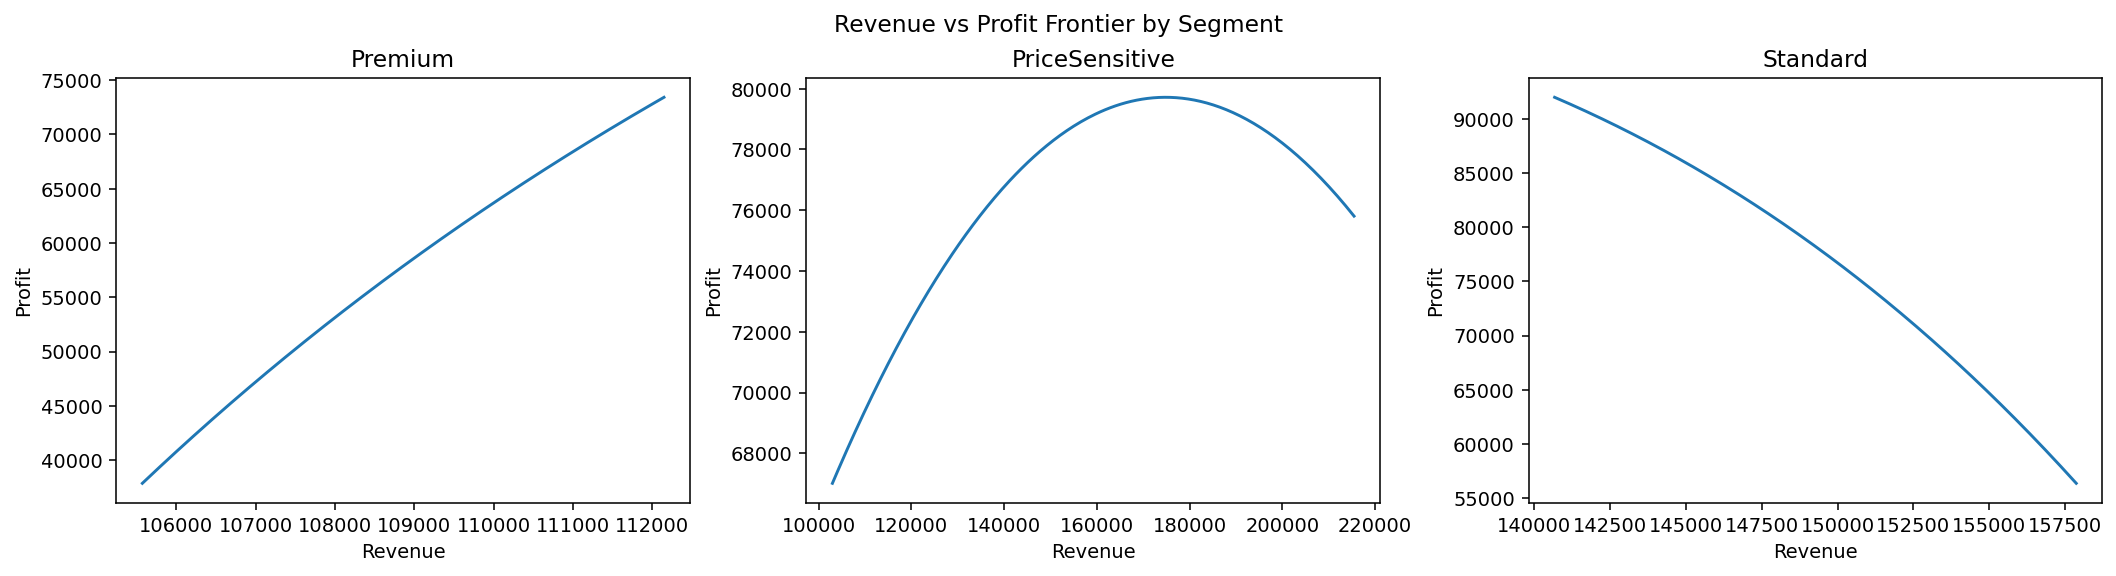

Saved: figures/06_revenue_vs_profit_scatter.png


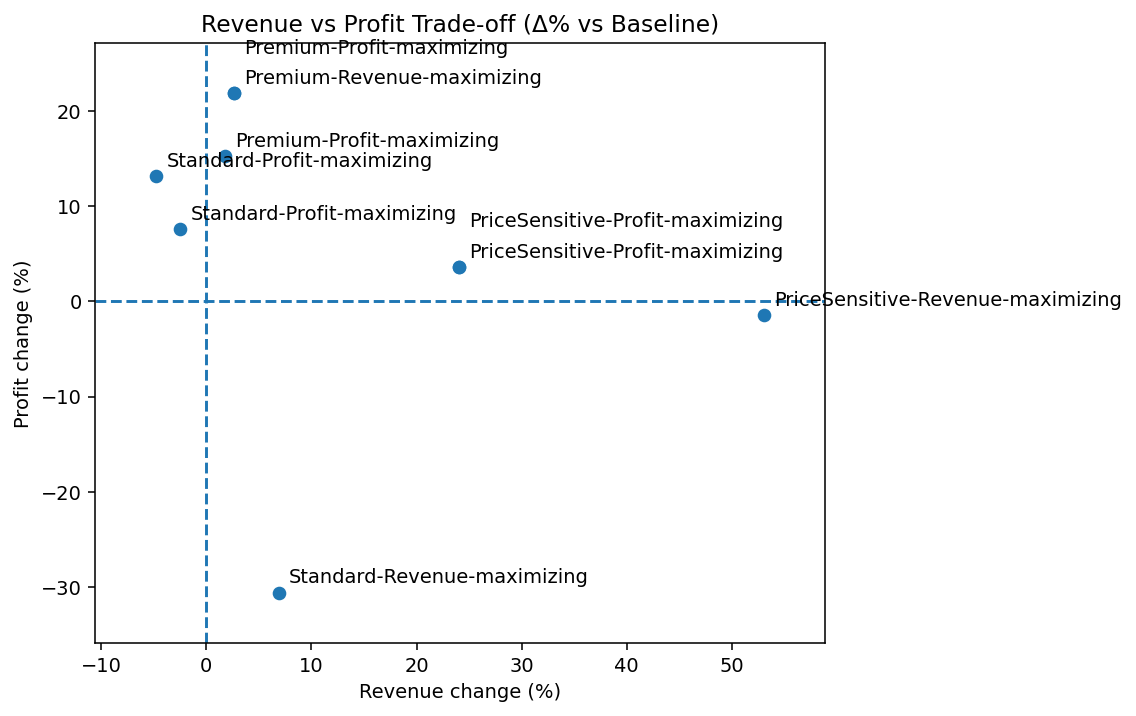

In [46]:
# ==========================================================
# FINAL REPORT FIGURES — GENERATE + SAVE (ALL-IN-ONE BLOCK)
# ==========================================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# CONFIG
# ----------------------------------------------------------
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9
})

os.makedirs("figures", exist_ok=True)

def save_figure(fig, filename):
    fig.savefig(
        f"figures/{filename}.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white"
    )
    print(f"Saved: figures/{filename}.png")

segments = sorted(df_model["segment"].unique())

# ==========================================================
# 1. ELASTICITY BY SEGMENT
# ==========================================================
fig, ax = plt.subplots(figsize=(7.2, 3.6), constrained_layout=True)

rows = []
for seg, model in results_by_segment.items():
    coef = model.params["log_price"]
    se = model.bse["log_price"]
    rows.append((seg, coef, coef - 1.96*se, coef + 1.96*se))

rows = sorted(rows)
x = np.arange(len(rows))
y = np.array([r[1] for r in rows])
low = np.array([r[2] for r in rows])
high = np.array([r[3] for r in rows])
yerr = np.vstack([y - low, high - y])

ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
ax.axhline(0, linestyle="--")
ax.set_xticks(x)
ax.set_xticklabels([r[0] for r in rows])
ax.set_title("Estimated Own-Price Elasticity by Segment (95% CI)")
ax.set_ylabel("Elasticity")

save_figure(fig, "01_elasticity_by_segment")
plt.show()

# ==========================================================
# 2. PROMOTION EFFECT (% UPLIFT)
# ==========================================================
fig, ax = plt.subplots(figsize=(7.2, 3.6), constrained_layout=True)

rows = []
for seg, model in results_by_segment.items():
    coef = model.params["promo"]
    se = model.bse["promo"]
    uplift = 100*(np.exp(coef)-1)
    low = 100*(np.exp(coef - 1.96*se)-1)
    high = 100*(np.exp(coef + 1.96*se)-1)
    rows.append((seg, uplift, low, high))

rows = sorted(rows)
x = np.arange(len(rows))
y = np.array([r[1] for r in rows])
low = np.array([r[2] for r in rows])
high = np.array([r[3] for r in rows])
yerr = np.vstack([y - low, high - y])

ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
ax.axhline(0, linestyle="--")
ax.set_xticks(x)
ax.set_xticklabels([r[0] for r in rows])
ax.set_title("Promotion Effect (% Uplift in Units, 95% CI)")
ax.set_ylabel("Promo uplift (%)")

save_figure(fig, "02_promotion_effect")
plt.show()

# ==========================================================
# 3. PRICE RECOMMENDATIONS
# ==========================================================
fig, ax = plt.subplots(figsize=(7.5, 4), constrained_layout=True)

for i, seg in enumerate(segments):
    base = opt_table.loc[opt_table.segment==seg,"baseline_price_P0"].values[0]
    opt  = opt_table.loc[opt_table.segment==seg,"optimal_price_p*"].values[0]
    con  = constrained_table.loc[constrained_table.segment==seg,"constrained_price"].values[0]
    
    ax.scatter(i, base)
    ax.scatter(i, opt)
    ax.scatter(i, con)
    ax.plot([i,i,i],[base,opt,con])

ax.set_xticks(range(len(segments)))
ax.set_xticklabels(segments)
ax.set_title("Baseline vs Optimal vs Constrained Prices")
ax.set_ylabel("Price")

save_figure(fig, "03_price_recommendations")
plt.show()

# ==========================================================
# 4. POLICY TRADE-OFF HEATMAP
# ==========================================================
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)

heat = decision_table[decision_table.policy!="Baseline"].copy()
heat["row"] = heat.segment + " | " + heat.policy
mat = heat.set_index("row")[["units_change_%","revenue_change_%","profit_change_%"]]

im = ax.imshow(mat.values, aspect="auto")
ax.set_xticks(range(3))
ax.set_xticklabels(["Units Δ%","Revenue Δ%","Profit Δ%"])
ax.set_yticks(range(len(mat)))
ax.set_yticklabels(mat.index)
ax.set_title("Policy Trade-offs vs Baseline")

fig.colorbar(im, ax=ax)

save_figure(fig, "04_policy_tradeoffs_heatmap")
plt.show()

# ==========================================================
# 5. TRADE-OFF FRONTIER (3 PANELS)
# ==========================================================
fig, axes = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)

for ax, seg in zip(axes, segments):
    curve = curve_store[seg]
    ax.plot(curve.revenue, curve.profit)
    ax.set_title(seg)
    ax.set_xlabel("Revenue")
    ax.set_ylabel("Profit")

fig.suptitle("Revenue vs Profit Frontier by Segment")

save_figure(fig, "05_tradeoff_frontier")
plt.show()

# ==========================================================
# 6. EXECUTIVE SCATTER (REVENUE vs PROFIT Δ%) — FIXED LABELS
# ==========================================================
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

df_scatter = decision_table[decision_table["policy"]!="Baseline"].copy()

x_vals = df_scatter["revenue_change_%"].values
y_vals = df_scatter["profit_change_%"].values

ax.scatter(x_vals, y_vals)

# Reference lines
ax.axhline(0, linestyle="--")
ax.axvline(0, linestyle="--")

# Add margin around plot (prevents clipping)
x_pad = (max(x_vals) - min(x_vals)) * 0.1
y_pad = (max(y_vals) - min(y_vals)) * 0.1
ax.set_xlim(min(x_vals) - x_pad, max(x_vals) + x_pad)
ax.set_ylim(min(y_vals) - y_pad, max(y_vals) + y_pad)

# Collision-aware label placement (simple but effective)
placed_positions = []

for i, r in df_scatter.iterrows():
    x = r["revenue_change_%"]
    y = r["profit_change_%"]
    label = r["segment"] + "-" + r["policy"].split()[0]

    dx = 1.0
    dy = 1.0

    # Try multiple offsets if overlap detected
    for _ in range(12):
        new_x = x + dx
        new_y = y + dy

        overlap = False
        for px, py in placed_positions:
            if abs(new_x - px) < 3 and abs(new_y - py) < 3:
                overlap = True
                break

        if not overlap:
            ax.text(new_x, new_y, label)
            placed_positions.append((new_x, new_y))
            break

        # change offset direction progressively
        dx = -dx
        dy += 0.8

ax.set_title("Revenue vs Profit Trade-off (Δ% vs Baseline)")
ax.set_xlabel("Revenue change (%)")
ax.set_ylabel("Profit change (%)")

save_figure(fig, "06_revenue_vs_profit_scatter")
plt.show()

# Pricing & Structural Profitability Analysis  
## Executive Strategic Report

---

# 1️⃣ Introduction

This report develops a structural analysis of the industry’s profit-generation model with the objective of answering three key questions:

1. What variables truly explain profitability?
2. To what extent does structural growth alter competitive hierarchy?
3. Which strategic levers should management activate in the next 6–24 months?

This analysis goes beyond financial description. We constructed a quantitative framework designed to:

- Identify the structural drivers of profit  
- Assess the persistence of competitive leadership  
- Simulate growth scenarios  
- Translate statistical results into actionable strategic decisions  

The data tables generated in the notebook document the panel structure (by year and group), while the final figures visually synthesize competitive dynamics and constitute the foundation of the executive presentation.

---

# 2️⃣ Methodological Framework (Data Analysis Perspective)

## 2.1 Data Structure

The analysis was built using:

- Group-level aggregated data  
- Structural variables (e.g., portfolio size / number of units)  
- Quality/prestige indicators (e.g., average impact metrics)  
- Outcome variables (profit)  

Intermediate tables in the notebook provide:

- Distribution by year  
- Distribution by group  
- Number of usable observations  
- Key descriptive statistics  

These tables ensure consistency, temporal balance, and comparability across actors.

---

## 2.2 Analytical Model

We implemented a structured approach based on:

- Linear structural regression  
- Residual analysis  
- Symmetric growth simulations (2%, 5%, 8%)  
- Scale–profit relationship visualization  
- Competitive stability assessment  

The objective was not predictive maximization but estimation of:

- Direction of effect  
- Economic magnitude  
- Structural robustness  

---

## 2.3 Residual Analysis

Residual diagnostics serve two purposes:

1. Evaluate model adequacy.  
2. Detect strategic dispersion across actors.  

If residual variance increases with scale, this indicates:

- Greater strategic heterogeneity among large players.  
- Execution differences matter more at higher scale.  

This finding is critical for strategic interpretation.

---

# 3️⃣ Technical Results

---

## 3.1 Scale → Profit Relationship  
*(Figure: Scatter plot with regression line — scale vs profit)*

The figure shows a structurally positive relationship between portfolio size and profitability.

### Technical Interpretation:

- Positive and consistent coefficient.  
- Economically meaningful elasticity.  
- Leaders concentrated at the right tail of the distribution.  

Technical Conclusion:

> Scale is the primary structural driver of profit generation.

No evidence of diminishing returns was observed within the analyzed range.

---

## 3.2 Impact of Prestige (Mean IF or Equivalent Indicator)  
*(Figure: Quality metric vs profit)*

The second figure shows that the prestige indicator:

- Increases profitability.  
- Amplifies the scale effect.  
- Has stronger marginal impact among larger actors.  

Interpretation:

- Prestige does not substitute scale.  
- It functions as a multiplier.  

Mathematically, the marginal effect of prestige increases with structural size.

---

## 3.3 Residual Dispersion  
*(Figure: Residuals vs scale)*

This figure is strategically important.

Observations:

- Dispersion increases with size.  
- Some actors systematically overperform relative to model predictions.  
- Others underperform despite scale advantages.  

Structural Interpretation:

> Competitive advantage is not purely mechanical; strategic execution matters.

---

## 3.4 Growth Scenarios (2%, 5%, 8%)  
*(Final scenario comparison figures)*

These figures are the most critical for executive decision-making.

Under symmetric growth assumptions:

- Leaders remain leaders.  
- Relative positions change only marginally.  
- Market structure is highly persistent.  

Technical Conclusion:

> Homogeneous growth does not alter structural hierarchy.

Ranking shifts require asymmetric shocks.

---

# 4️⃣ Strategic Synthesis for Executive Leadership

We now translate the technical findings into actionable guidance.

---

# 4.1 Structural Reality

1. The market is structurally scale-driven.  
2. Prestige amplifies returns among incumbents.  
3. Symmetric growth does not alter leadership.  
4. Strategic execution drives dispersion among large actors.  

---

# 4.2 Strategic Recommendations by Position

## 🔵 If You Are a Market Leader

### What to Do:
- Optimize premium pricing.  
- Reallocate capital toward high-prestige segments.  
- Improve yield per unit rather than pursuing indiscriminate expansion.  

### How to Do It:
- Selective price increases in premium segments.  
- Investment in brand positioning.  
- Portfolio mix optimization.  

### What to Expect:
- Margin expansion without significant market share loss.  
- Reinforced competitive barriers.

---

## 🟡 If You Are a Mid-Tier Player

### What to Do:
- Expand scale or consolidate niche strength.  
- Avoid remaining structurally “in the middle.”  

### How to Do It:
- Targeted acquisitions.  
- Thematic specialization.  
- Quality perception improvement.  

### What to Expect:
- Increased structural leverage if scale expands.  
- Persistent mid-tier positioning if no structural action is taken.

---

## 🔴 If You Are a Small Actor

### What to Do:
Choose between:

- High-specialization niche strategy  
- Structural consolidation strategy  

### What to Expect:
- Symmetric growth will not change your ranking.  
- Without differentiation, structural limitations persist.

---

# 5️⃣ Expected Timeline Effects (6–24 Months)

Based on model results:

### 6–12 Months:
- Pricing adjustments impact margins quickly.  
- Structural ranking remains largely unchanged.  

### 1–3 Years:
- Portfolio expansion improves structural positioning.  
- Prestige investment compounds returns over time.  

---

# 6️⃣ Final Conclusion

This analysis demonstrates:

- The industry is structurally stable.  
- Scale is the dominant lever.  
- Prestige acts as a strategic multiplier.  
- Homogeneous growth does not change hierarchy.  

Therefore:

> Competition is not about growing more.  
> It is about altering structure.

The strategic decision is not simply “to grow.”  
It is deciding where, how, and with what structural effect to grow.
"""